Sadly, I lost all my previous codes. So I will speedrun the adaptation of white light CCF in this notebook.

For now, I will ignore the part of profile fitting. I just want to extract the local spectra.

Also only the 11/08/2021 night.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import dfitspy
import os
import glob
from matplotlib.colors import Normalize
from scipy.sparse import lil_matrix
from scipy.stats import spearmanr

from ldtk import LDPSetCreator, BoxcarFilter
import SOAP # type: ignore

In [3]:
#### Folder where the images are located
directory_path = 'Eduardos_code/white_light_ccfs/'
listfiles=glob.glob(os.path.join(directory_path, '*.fits'))

listkeys=['DATE-OBS','HIERARCH ESO QC BJD']
fitsort = dfitspy.dfitsort(listfiles, listkeys,exact=True)
dfitspy.dfitsort_view(fitsort)

                    filename                     	       DATE-OBS        	HIERARCH ESO QC BJD
-------------------------------------------------	-----------------------	-------------------
r.ESPRE.2021-08-31T02_39_59.908_CCF_SKYSUB_A.fits	2021-08-31T02:39:59.908	 2459457.61727296  
r.ESPRE.2021-08-31T02_58_01.354_CCF_SKYSUB_A.fits	2021-08-31T02:58:01.354	 2459457.62995938  
r.ESPRE.2021-08-31T04_34_15.697_CCF_SKYSUB_A.fits	2021-08-31T04:34:15.697	  2459457.6967514  
r.ESPRE.2021-08-31T00_51_49.573_CCF_SKYSUB_A.fits	2021-08-31T00:51:49.573	 2459457.54226715  
r.ESPRE.2021-08-11T00_51_07.338_CCF_SKYSUB_A.fits	2021-08-11T00:51:07.338	 2459437.54224261  
r.ESPRE.2021-08-11T01_45_19.180_CCF_SKYSUB_A.fits	2021-08-11T01:45:19.180	 2459437.57993129  
r.ESPRE.2021-08-11T04_39_24.065_CCF_SKYSUB_A.fits	2021-08-11T04:39:24.064	 2459437.70013906  
r.ESPRE.2021-08-31T03_28_05.180_CCF_SKYSUB_A.fits	2021-08-31T03:28:05.179	 2459457.65081538  
r.ESPRE.2021-08-11T03_45_22.093_CCF_SKYSUB_A.fits	2021-08-11

In [4]:
#List files names in order
list_ccfs = []
for name in listfiles:
    if '2021-08-11' in name and 'SKY' in name:
        list_ccfs.append(name)
print(len(list_ccfs),list_ccfs)

list_ccfs = sorted(list_ccfs)

#removing low SNR observation
list_ccfs = list_ccfs[:-1]

print(len(list_ccfs),list_ccfs)

41 ['Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T00_51_07.338_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T01_45_19.180_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T04_39_24.065_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T03_45_22.093_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T02_57_20.533_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T02_45_18.607_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T03_33_23.219_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T04_09_20.370_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T01_39_17.063_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T04_33_24.353_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T01_33_17.472_CCF_SKYSUB_A.fits', 'Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T02_39_18.803_CCF_SKYS

In [5]:
file_test = directory_path+'r.ESPRE.2021-08-11T00_51_07.338_CCF_SKYSUB_A.fits'

hdutest = fits.open(file_test)
hdutest.info()
hdutest.close()

Filename: Eduardos_code/white_light_ccfs/r.ESPRE.2021-08-11T00_51_07.338_CCF_SKYSUB_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1474   ()      
  1  SCIDATA       1 ImageHDU        10   (81, 171)   float32   
  2  ERRDATA       1 ImageHDU        10   (81, 171)   float32   
  3  QUALDATA      1 ImageHDU        10   (81, 171)   int32   


In [6]:
#checking the header
f = fits.getdata(file_test,1)
f1 = fits.getdata(file_test,2)
fh = fits.getheader(file_test)
fh #HIERARCH ESO OBS START

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2021-08-12T00:29:10' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U1'         / ESO <TEL>                                      
INSTRUME= 'ESPRESSO'           / Instrument used.                               
OBJECT  = 'HD 189733'          / Original target.                               
RA      =           300.182485 / [deg] 20:00:43.7 RA (J2000) pointing           
DEC     =             22.709

In [7]:
#opening and storing white light CCFs day 11
CCFs = np.zeros((len(list_ccfs),2, f.shape[1]))
CCF_rv = np.zeros((len(list_ccfs),f.shape[1]))
Time = []
Air = []

RV_reference = 0

for i,name in enumerate(list_ccfs):

    d = fits.getdata(name,1)
    de = fits.getdata(name,2)
    h = fits.getheader(name)

    N = len(d[-1])
    a = h['HIERARCH ESO RV START']
    step = h['HIERARCH ESO RV STEP']
    t = h['HIERARCH ESO QC BJD']
    air = h['HIERARCH ESO TEL1 AIRM START']
    Time.append(t)
    Air.append(air)
    X = np.arange(a,a+step*N,step)

    CCFs[i,0,:] = d[-1]
    CCFs[i,1,:] = de[-1]
    CCF_rv[i] = X

    if i == 0:
        RV_reference = X + 2
    
Time = np.array(Time)
Air = np.array(Air)

## Fitting modified gaussian

In [8]:
from scipy.optimize import curve_fit

def modified_gaussfit(x,y0,a,x0,sigma,c):
    return y0-a*np.exp(-0.5*((np.abs(x-x0)/sigma)**c))

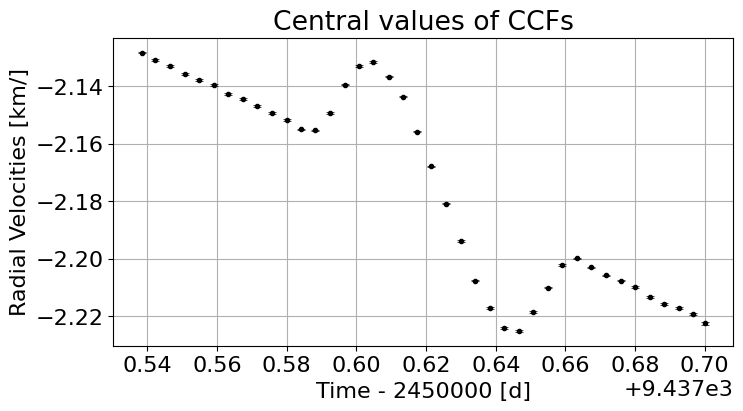

In [9]:
y0 = np.zeros((len(list_ccfs),2))
x0 = np.zeros((len(list_ccfs),2))

for i in range(len(list_ccfs)):
    d = CCFs[i,0]
    de = CCFs[i,1]
    rv = CCF_rv[i]


    p0 =          [np.max(d), np.max(d)-np.min(d),           0,       1,       1] #y0, a, x0, sigma, c
    upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
    lower_bound = [        0,                   0,  np.min(rv),       0,       0]


    popt, pcov = curve_fit(f=modified_gaussfit, xdata=rv, ydata=d, sigma=de, 
                           bounds=(lower_bound,upper_bound), absolute_sigma=True, p0=p0)

    x0[i,0], x0[i,1] = popt[2], np.sqrt(pcov[2,2])
    y0[i,0], y0[i,1] = popt[0], np.sqrt(pcov[0,0])


plt.figure(figsize=(8,4))
plt.errorbar(x=Time-2450000,y=x0[:,0],yerr = x0[:,1], capsize=3, capthick=0.5, fmt="k.")
plt.ylabel('Radial Velocities [km/]')
plt.xlabel('Time - 2450000 [d]')
plt.title('Central values of CCFs')
plt.grid()
plt.show()


In [10]:
def phase(date,tepoch, P_orb):
    norb = (date-tepoch)/P_orb
    nforb = [round(x) for x in norb]
    return norb-nforb

In [11]:
#cristo et al.
#table 4
Vsys = -2.18095 #km/s
Prot = 11.454 #dias
istar = 71.87 #º
alphaB = 0.29
VCB = -211 #m/s
ip = 85.465 #º
lamda = -1.00 #º
aR = 8.7686 #in star radiuses
RpRs = 0.1602
mp =  356.9 #m⊕
dfp = -0.002424
alphaw = -50.4 #cm/s
#table E.1
Rstar = 0.766 #R⊙
Teff = 4969 #K
e_Teff = 43
P_orb = 2.21857312 #dias
T0 = 53988.30339

logg = 4.60 
e_logg = 0.01
feh = -0.07
e_feh = 0.02

In [12]:
tepoch = T0 + 0.5+2.4e6 -dfp*P_orb#MBJD

phases = phase(Time, tepoch, P_orb)
print(phases) #em Porbit

[-0.03878006 -0.03700934 -0.03514845 -0.03318259 -0.03133248 -0.02944812
 -0.02757787 -0.02564173 -0.0237944  -0.02191848 -0.02002154 -0.01812612
 -0.01628159 -0.01441559 -0.0124982  -0.0106569  -0.008787   -0.00682509
 -0.00500114 -0.00311627 -0.00126897  0.0006282   0.00254259  0.00440799
  0.00626933  0.00817742  0.01004104  0.01192976  0.01379679  0.0156898
  0.01753608  0.01941469  0.02131465  0.02321891  0.02502994  0.02699783
  0.02883662  0.03071907  0.03260208  0.03416093]


In [ ]:
tr_dur=1./np.pi * np.arcsin(1./aR *np.sqrt((1+RpRs)**2.-aR**2. *np.cos(np.radians(ip))**2.))

tr_ingress_egress=1./np.pi * np.arcsin(1./aR *np.sqrt((1.-RpRs)**2.-aR**2. *np.cos(np.radians(ip))**2.))

Text(0.5, 1.0, 'Airmass at start of observation in function of orbital phases')

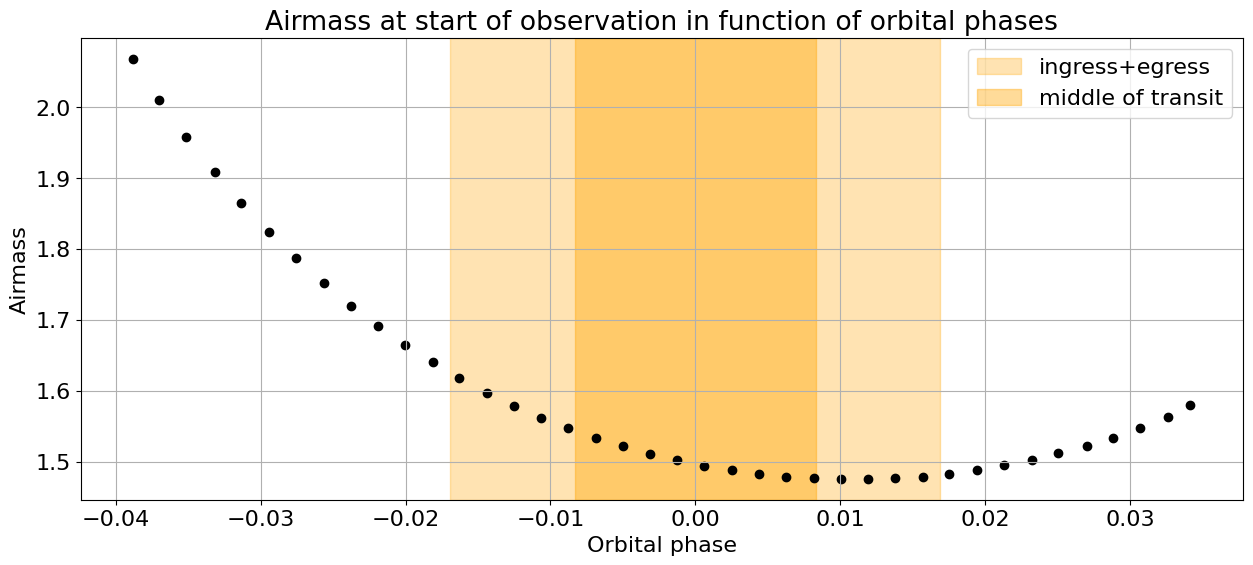

In [14]:
plt.figure(figsize=(15,6))
plt.axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange',label='ingress+egress')
plt.axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange',label='middle of transit')
plt.scatter(phases, Air,color='black')
plt.xlabel('Orbital phase')
plt.grid()
plt.ylabel('Airmass')
plt.legend()
plt.title('Airmass at start of observation in function of orbital phases')

## RV correction and normalization

In [15]:
out_indices = np.where(np.abs(phases) >  tr_dur/2)[0]
in_indices  = np.where(np.abs(phases) <= tr_dur/2)[0]

poly_coefs, poly_cov = np.polyfit(phases[out_indices], x0[:,0][out_indices], w=1/x0[:,1][out_indices],deg=1,cov=True)

x0_corr = np.zeros_like(x0)
CCFs_corr = np.zeros_like(CCFs)
CCF_rv_corr = np.zeros_like(CCF_rv)

for i in range(len(list_ccfs)):
    d = CCFs[i,0]
    de = CCFs[i,1]
    
    d_corr = d/y0[i,0]
    
    x0_corr[i,0] = x0[i,0] - (poly_coefs[0]*phases[i] + poly_coefs[1])
    CCF_rv_corr[i] = CCF_rv[i] - (poly_coefs[0]*phases[i] + poly_coefs[1])
    CCFs_corr[i,0] = d_corr

    CCFs_corr[i,1] = d_corr * np.sqrt( (y0[i,1]/y0[i,0])**2 + (de/d)**2 )
    x0_corr[i,1] = np.sqrt( x0[i,1]**2 + poly_cov[0,0]*phases[i]**2 + poly_cov[1,1])

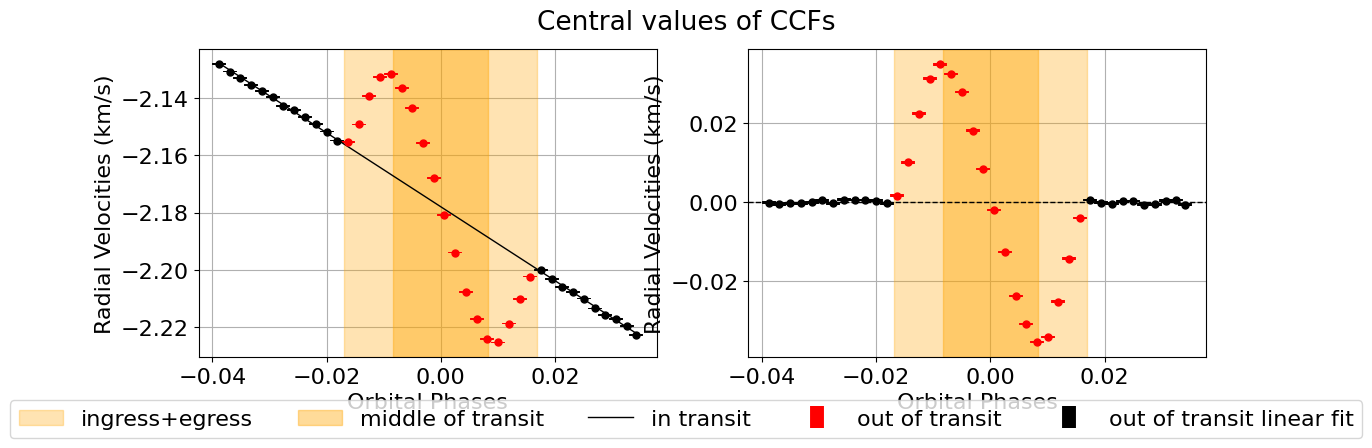

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(13,4))

l0 = axes[0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
l1 = axes[0].axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange')
l2 = axes[0].errorbar(phases[in_indices], x0[:,0][in_indices], x0[:,1][in_indices], fmt="r.", markersize=10, elinewidth=10)
l3 = axes[0].errorbar(phases[out_indices], x0[:,0][out_indices], x0[:,1][out_indices], fmt="k.", markersize=10, elinewidth=10)
l4 = axes[0].plot(phases[out_indices], poly_coefs[:,0]*phases[out_indices]+poly_coefs[1], color="black", lw=1)

axes[0].set_ylabel('Radial Velocities (km/s)')
axes[0].set_xlabel('Orbital Phases')
axes[0].grid()
axes[0].set_axisbelow(True)


axes[1].axvspan(-tr_dur/2, tr_dur/2, alpha=0.3, color="orange")
axes[1].axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange')
axes[1].errorbar(phases[in_indices], x0_corr[:,0][in_indices], x0_corr[:,1][in_indices], fmt="r.", markersize=10, elinewidth=10)
axes[1].errorbar(phases[out_indices], x0_corr[:,0][out_indices], x0_corr[:,1][out_indices], fmt="k.", markersize=10, elinewidth=10)
axes[1].axhline(0, lw=1, ls= "--", color="k")
axes[1].set_ylabel('Radial Velocities (km/s)')
axes[1].set_xlabel('Orbital Phases')
axes[1].grid()
axes[1].set_axisbelow(True)

labels = ['ingress+egress','middle of transit','in transit','out of transit','out of transit linear fit']
fig.legend([l0,l1,l2,l3,l4], labels=labels, loc='lower center',ncol=5, bbox_to_anchor=(0.5, -0.12))
fig.suptitle('Central values of CCFs',fontsize=19)
plt.show()

In [17]:
M = CCFs_corr.shape[0]
K = CCFs_corr.shape[2]
cov_matrix = np.zeros((M, K, K))
N = 10000

for i in range(M):
    samples = np.zeros((K, N))
    for j in range(K):
        ymean = CCFs_corr[i,0,j]
        ysigma = CCFs_corr[i,1,j]
        samples[j,:] = np.random.normal(ymean, ysigma, N)
    cov_ccf = np.cov(samples)
    cov_matrix[i,:,:] = cov_ccf

In [18]:
def linear_interpolation_matrix(x_old, x_new):
    """
    Builds a sparse matrix W that linearly interpolates data from x_old → x_new.
    Each row i corresponds to interpolation weights for x_new[i].
    """
    W = lil_matrix((len(x_new), len(x_old)))

    for i, xv in enumerate(x_new):
        if xv <= x_old[0]:
            # extrapolate using first two points
            j = 0
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)
        elif xv >= x_old[-1]:
            # extrapolate using last two points
            j = len(x_old) - 2
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)
        else:
            j = np.searchsorted(x_old, xv) - 1
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)

        W[i, j]   = w1
        W[i, j+1] = w2

    return W.tocsr()


# Preallocate results
out_of_transit_CCFs = np.zeros([len(out_indices), len(RV_reference), 2])
in_transit_CCF = np.zeros([CCFs.shape[0] - len(out_indices), len(RV_reference)])

interp_CCF_flux = np.zeros([CCFs.shape[0], CCFs.shape[2], 2])

k, M = 0, 0
RV_target = RV_reference  # your adjusted target grid

for l in range(CCFs.shape[0]):
    ccf_f = CCFs_corr[l,0]
    ccf_f_e = cov_matrix[l]       # full covariance matrix
    ccf_rv = CCF_rv_corr[l]

    # Build interpolation matrix for this CCF → target grid
    W = linear_interpolation_matrix(ccf_rv, RV_target)

    # Interpolated flux
    y_i = W @ ccf_f

    # Propagated covariance and uncertainty
    cov_new = W @ ccf_f_e @ W.T
    y_i_e = np.sqrt(cov_new.diagonal())

    interp_CCF_flux[l,:,0] = y_i
    interp_CCF_flux[l,:,1] = y_i_e

    # Separate out-of-transit vs in-transit
    if l in out_indices:
        out_of_transit_CCFs[k,:,0] = y_i
        out_of_transit_CCFs[k,:,1] = y_i_e
        k += 1
    else:
        in_transit_CCF[M] = y_i
        M += 1

# Compute master out-of-transit CCF and its uncertainty
average_out_of_transit_CCF = np.mean(out_of_transit_CCFs[:,:,0], axis=0)
A_e = np.sum(out_of_transit_CCFs[:,:,1]**2, axis=0)
average_out_of_transit_CCF_e = np.sqrt(A_e) / len(out_indices)


avg_out_of_transit_CCF = np.array([average_out_of_transit_CCF, average_out_of_transit_CCF_e])
avg_out_of_transit_CCF

array([[1.01560968e+00, 1.01355346e+00, 1.01152145e+00, 1.00960120e+00,
        1.00774582e+00, 1.00595622e+00, 1.00424555e+00, 1.00253844e+00,
        1.00087066e+00, 9.99178139e-01, 9.97337099e-01, 9.95325917e-01,
        9.93080330e-01, 9.90615586e-01, 9.87921085e-01, 9.85048826e-01,
        9.81976925e-01, 9.78661862e-01, 9.75091405e-01, 9.71148106e-01,
        9.66704766e-01, 9.61443880e-01, 9.54920964e-01, 9.46539081e-01,
        9.35663622e-01, 9.21568951e-01, 9.03366841e-01, 8.80240054e-01,
        8.51547429e-01, 8.16927165e-01, 7.76420237e-01, 7.30505691e-01,
        6.80301068e-01, 6.27361827e-01, 5.73761433e-01, 5.21888899e-01,
        4.74436522e-01, 4.34007278e-01, 4.02959534e-01, 3.83299437e-01,
        3.76384966e-01, 3.82703147e-01, 4.01915860e-01, 4.32705131e-01,
        4.73165584e-01, 5.20890748e-01, 5.73144051e-01, 6.27207926e-01,
        6.80578730e-01, 7.31050084e-01, 7.77071656e-01, 8.17712771e-01,
        8.52480767e-01, 8.81411573e-01, 9.04984643e-01, 9.238559

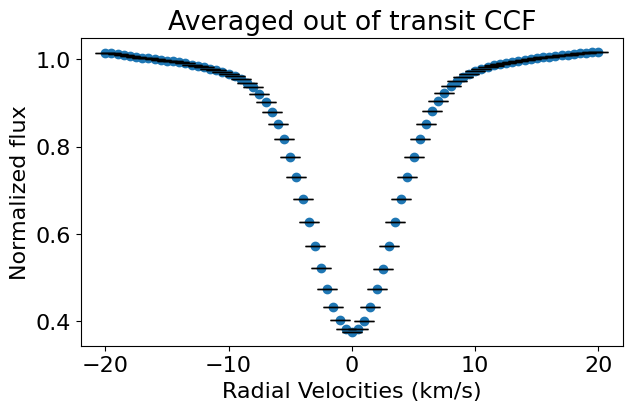

In [19]:
plt.figure(figsize=(7,4))
plt.scatter(RV_reference, avg_out_of_transit_CCF[0])
plt.errorbar(x=RV_reference, y=avg_out_of_transit_CCF[0],yerr =avg_out_of_transit_CCF[1],capsize=7,capthick=1,color='black',linewidth=0,elinewidth=1)
plt.title('Averaged out of transit CCF')
plt.xlabel('Radial Velocities (km/s)')
plt.ylabel('Normalized flux')
plt.show()

## Photometric light curve

In [20]:
#coeficientes de limb darkening
filters = [BoxcarFilter('filter', 380, 788)] #expresso spectograph bandpass 380, 788nm
sc = LDPSetCreator(teff=(Teff, e_Teff),  
logg=(logg, e_logg),
z=(feh, e_feh),
filters=filters)
ps = sc.create_profiles()      	         #create the limb darkening profiles
ldcn, qe = ps.coeffs_qd(do_mc=True) #coeficientes e os seus erros de perfil quadrático
ldcn

array([[0.6461717, 0.0845909]])

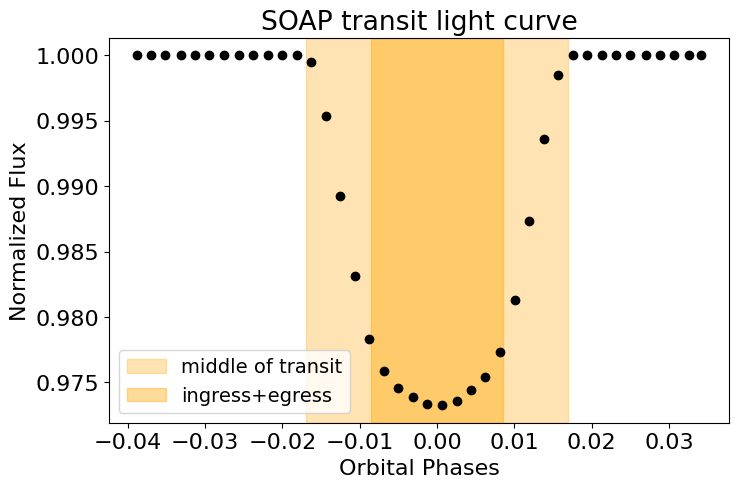

In [21]:
#curva de luz
sim = SOAP.Simulation()
sim.star.set(prot = Prot,incl =istar,radius=Rstar,teff=Teff,u1=ldcn[0,0], u2=ldcn[0,1])
sim.planet.set(P=P_orb, t0=0, e=0.0, w=90.0,ip=ip,lbda=lamda,a=aR,Rp=RpRs)

output = sim.calculate_signal(psi=phases/Prot*P_orb,skip_rv=True)
Flux_SOAP = output.flux

fig = plt.figure(figsize=(8,5))

plt.axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange', label="middle of transit")
plt.axvspan(-tr_ingress_egress/2., tr_ingress_egress/2., alpha=0.4, color='orange', label="ingress+egress")
plt.scatter(phases, Flux_SOAP, color="k")
plt.title('SOAP transit light curve')
plt.ylabel("Normalized Flux")
plt.xlabel("Orbital Phases")
plt.legend(fontsize=14)

plt.show()

## Local white light CCFs

In [ ]:
CCFs_flux_corr = np.zeros_like(CCFs_corr) #only flux corrected
CCFs_sub_all = np.zeros_like(CCFs_corr) #flux corrected and subtracted
local_CCFs = np.zeros((len(in_indices), 2, CCFs_corr.shape[2])) #above but only in transit

l = 0
for i in range(CCFs_flux_corr.shape[0]):

    d = interp_CCF_flux[i,:,0]
    de = interp_CCF_flux[i,:,1]
    
    #performing the Doppler shadow technique
    sub = avg_out_of_transit_CCF[0] - d*Flux_SOAP[i]

    d_corr = d*Flux_SOAP[i]
    de_corr = np.sqrt(avg_out_of_transit_CCF[1]**2+(de*Flux_SOAP[i])**2)

    CCFs_sub_all[i,0] = sub
    CCFs_sub_all[i,1] = de_corr

    if i in in_indices:
        
        CCFs_flux_corr[i,0] = d_corr
        CCFs_flux_corr[i,1] = de*Flux_SOAP[i]

        local_CCFs[l,0] = sub
        local_CCFs[l,1] = de_corr

        l += 1

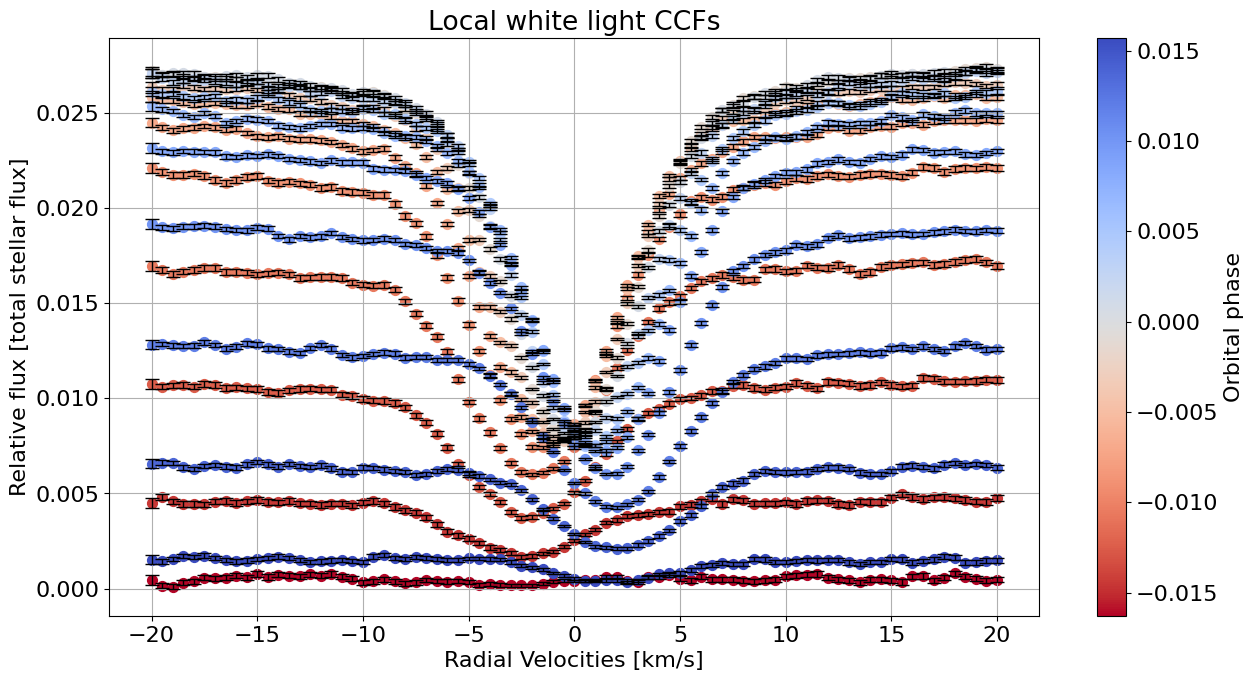

In [57]:
fig, axes = plt.subplots(figsize=(15,7.5))

norm = Normalize(vmin=phases[in_indices].min(), vmax=phases[in_indices].max())
cmap = plt.get_cmap('coolwarm_r')

for k, idx in enumerate(in_indices):

    sub     = local_CCFs[k,0]
    de_corr = local_CCFs[k,1]

    color = cmap(norm(phases[idx]))

    axes.scatter(RV_target, sub, color=color, s=50, label=str(phases[idx])[:6])
    axes.errorbar(RV_target, sub, yerr=de_corr,
                    color='black', capsize=5, linewidth=0, elinewidth=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=axes)
cbar.set_label('Orbital phase')

axes.set_title('Local white light CCFs')
axes.set_ylabel('Relative flux [total stellar flux]')
axes.set_xlabel('Radial Velocities [km/s]')
axes.grid()
plt.show()

## Fits

In [33]:
def r2(y,yfit):
    ssres = np.sum((y-yfit)**2)
    sstot = np.sum((y-np.mean(y))**2)
    r = 1- ssres/sstot
    return r

In [104]:
#impact parameter
b = aR*np.cos(ip*np.pi/180)

# calculating minimum and maximum mu for the shaded regions in the plots
def mu(phases):
    return np.sqrt(1 - b**2 - (aR*np.sin(2*np.pi*np.abs(phases)))**2 )
mu_min = mu(tr_dur/2-tr_ingress_egress/2)
mu_max = mu(0)

y_0 = 0.9997±4.9372, a = 0.6295±1.0524, x_0 = -0.000±4.9174, sigma = 3.4045±9.0082, c = 1.8237±8.4584


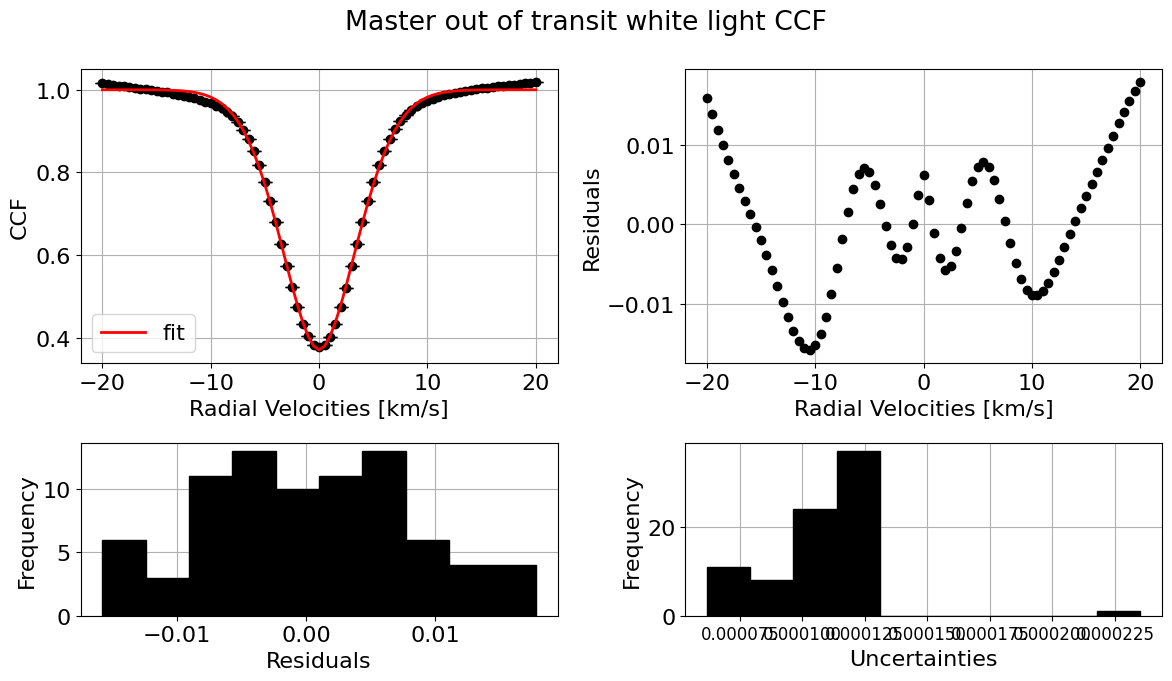

R^2:  0.998347960392883


In [ ]:
#MASTER OUT OF TRANSIT parameter fitting for comparison
p0 =          [np.max(avg_out_of_transit_CCF[0]), np.max(avg_out_of_transit_CCF[0])-np.min(avg_out_of_transit_CCF[0]),           0,       1,       1] #y0, a, x0, sigma, c
upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
lower_bound = [        0,                   0,  np.min(rv),       0,       0]


popt, pcov = curve_fit(f=modified_gaussfit, xdata=RV_target, ydata=avg_out_of_transit_CCF[0], sigma=avg_out_of_transit_CCF[1], bounds = (lower_bound,upper_bound), absolute_sigma=True, p0=p0)
gd = modified_gaussfit(RV_target,popt[0],popt[1],popt[2],popt[3],popt[4])

print('y_0 = '+str(popt[0])[:6]+'±'+str(np.sqrt(pcov[0,0]))[:6]+', a = '+str(popt[1])[:6]+'±'+str(np.sqrt(pcov[1,1]))[:6]+', x_0 = '+str(popt[2])[:6]+'±'+str(np.sqrt(pcov[2,2]))[:6]+', sigma = '+str(popt[3])[:6]+'±'+str(np.sqrt(pcov[3,3]))[:6]+', c = '+str(popt[4])[:6]+'±'+str(np.sqrt(pcov[4,4]))[:6])

master_x0 = popt[2]
master_x0_err = np.sqrt(pcov[2,2])

master_depth = (1-(popt[1]/popt[0]))*100
master_depth_err = ((popt[1]/popt[0])*np.sqrt(np.abs(pcov[1,1])/(popt[1]**2)+np.abs(pcov[0,0])/(popt[0]**2)))*100

master_width = popt[3] 
master_width_err = np.sqrt(pcov[3,3])

master_y0 = popt[0]
master_y0_err = np.sqrt(pcov[0,0])


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7), gridspec_kw={'height_ratios': [1.7, 1]})
fig.suptitle('Master out of transit white light CCF')

axes[0,0].scatter(RV_target, avg_out_of_transit_CCF[0], color="k")
axes[0,0].errorbar(RV_target, avg_out_of_transit_CCF[0], yerr=avg_out_of_transit_CCF[1],
                    color='black', capsize=5, linewidth=0, elinewidth=1)
axes[0,0].plot(RV_target,gd,label='fit', color="r", lw=2)
axes[0,0].set_xlabel('Radial Velocities [km/s]')
axes[0,0].set_ylabel('CCF')
axes[0,0].grid()
axes[0,0].set_axisbelow(True)
axes[0,0].legend()


axes[0,1].scatter(RV_target, avg_out_of_transit_CCF[0]-gd, color="k")
axes[0,1].set_xlabel('Radial Velocities [km/s]')
axes[0,1].set_ylabel('Residuals')
axes[0,1].grid()
axes[0,1].set_axisbelow(True)


axes[1,0].hist(avg_out_of_transit_CCF[0]-gd, bins=10, edgecolor='k', color="k")
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid()
axes[1,0].set_axisbelow(True)

axes[1,1].hist(de, bins=10, edgecolor='k', color="k")
axes[1,1].set_xlabel('Uncertainties')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid()
axes[1,1].set_axisbelow(True)
axes[1,1].tick_params(axis='x', which='major', labelsize=12)

plt.tight_layout()
plt.show()

print("R^2: ", r2(avg_out_of_transit_CCF[0],gd))

y_0 = 0.0005±1.9171, a = 0.0003±7.7589, x_0 = -3.256±0.2990, sigma = 1.8511±0.6579, c = 1.5000±0.6505


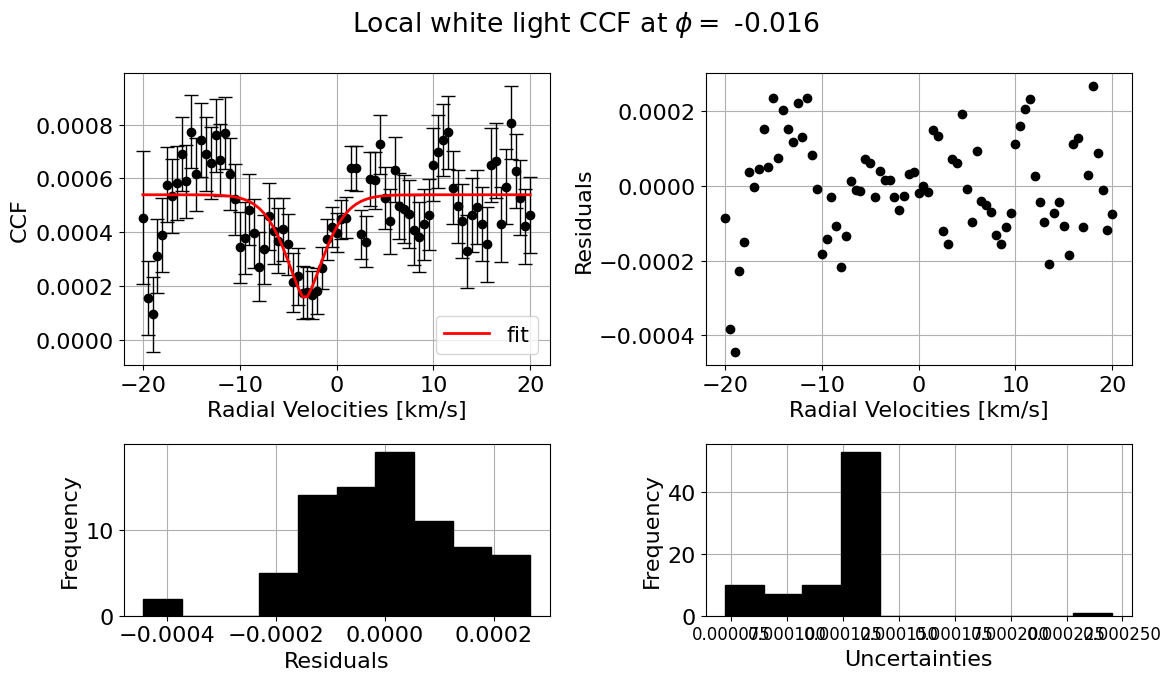

y_0 = 0.0045±2.2596, a = 0.0029±5.9840, x_0 = -2.362±0.0491, sigma = 2.9066±0.0939, c = 1.7897±0.0943


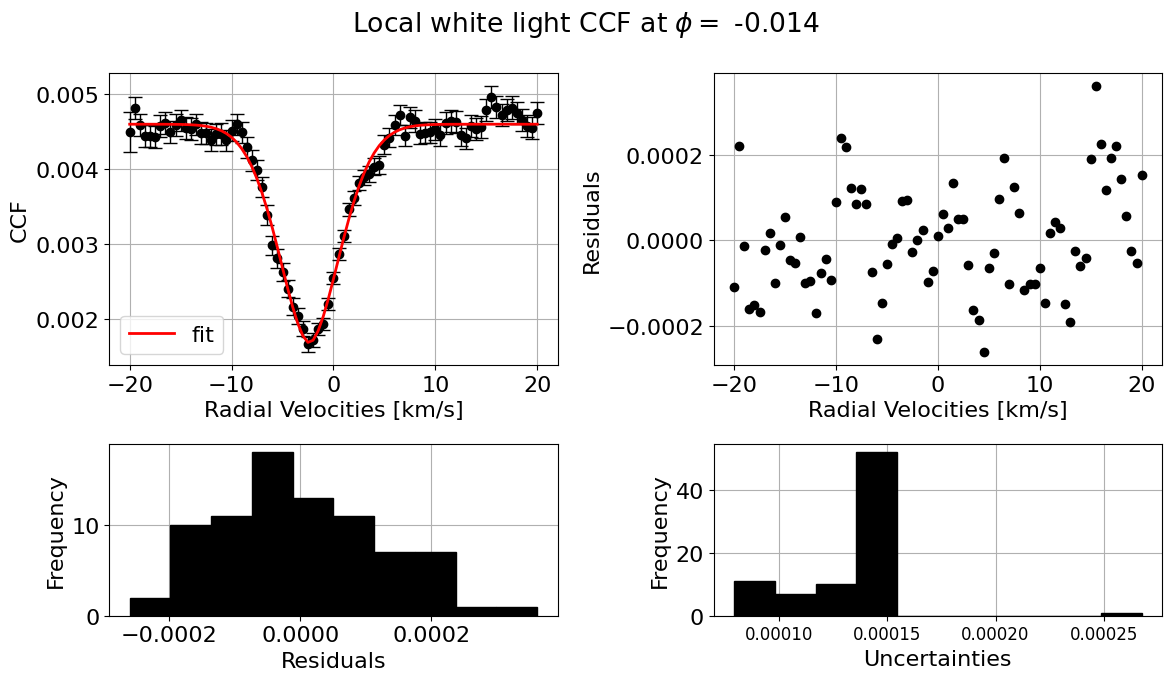

y_0 = 0.0106±2.1897, a = 0.0069±5.3852, x_0 = -2.107±0.0204, sigma = 3.1354±0.0371, c = 1.9230±0.0406


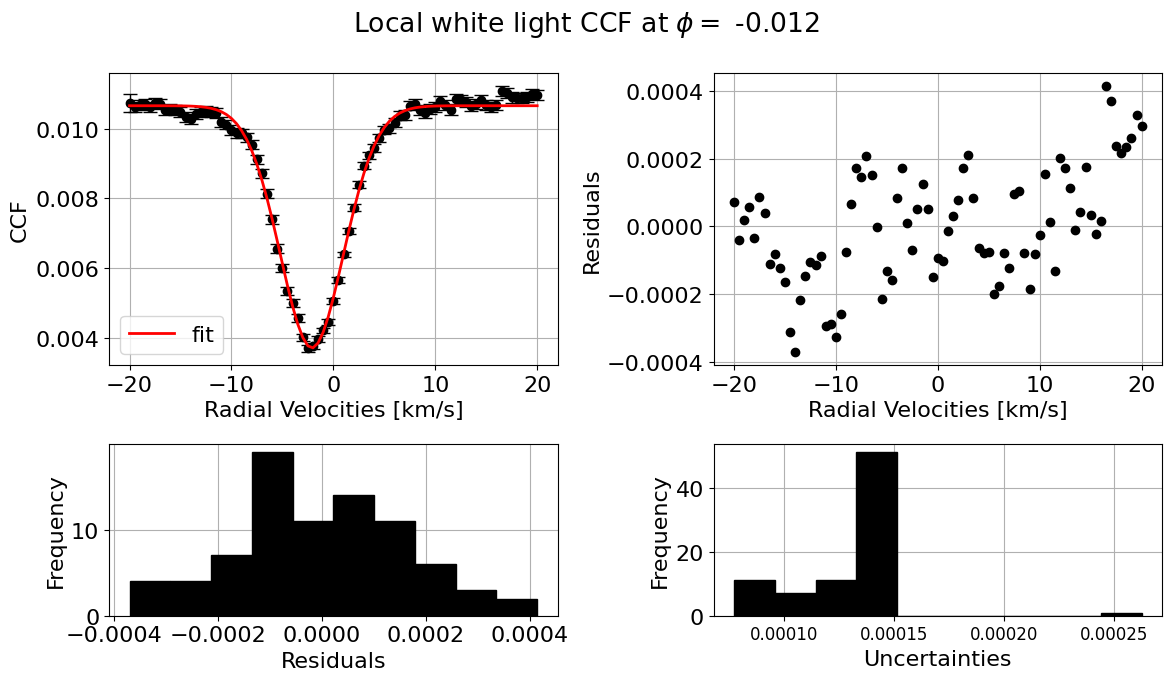

y_0 = 0.0167±2.2600, a = 0.0108±5.3577, x_0 = -1.818±0.0134, sigma = 3.2039±0.0239, c = 1.9779±0.0275


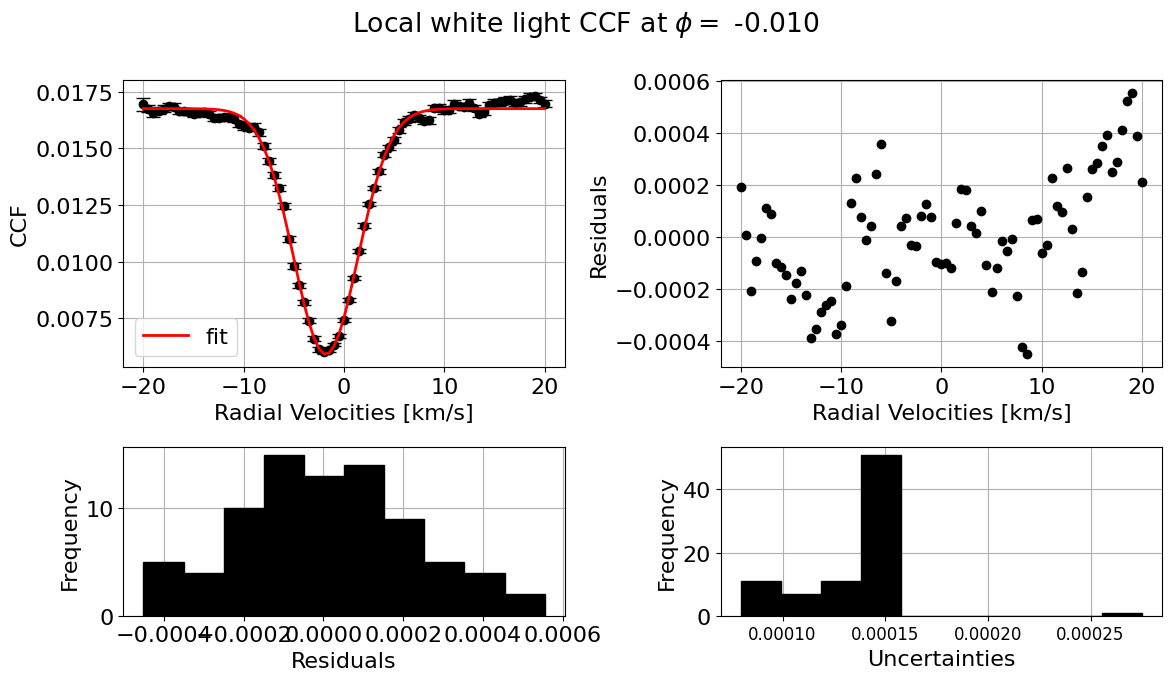

y_0 = 0.0216±2.3089, a = 0.0143±5.4408, x_0 = -1.470±0.0102, sigma = 3.1497±0.0184, c = 1.9286±0.0204


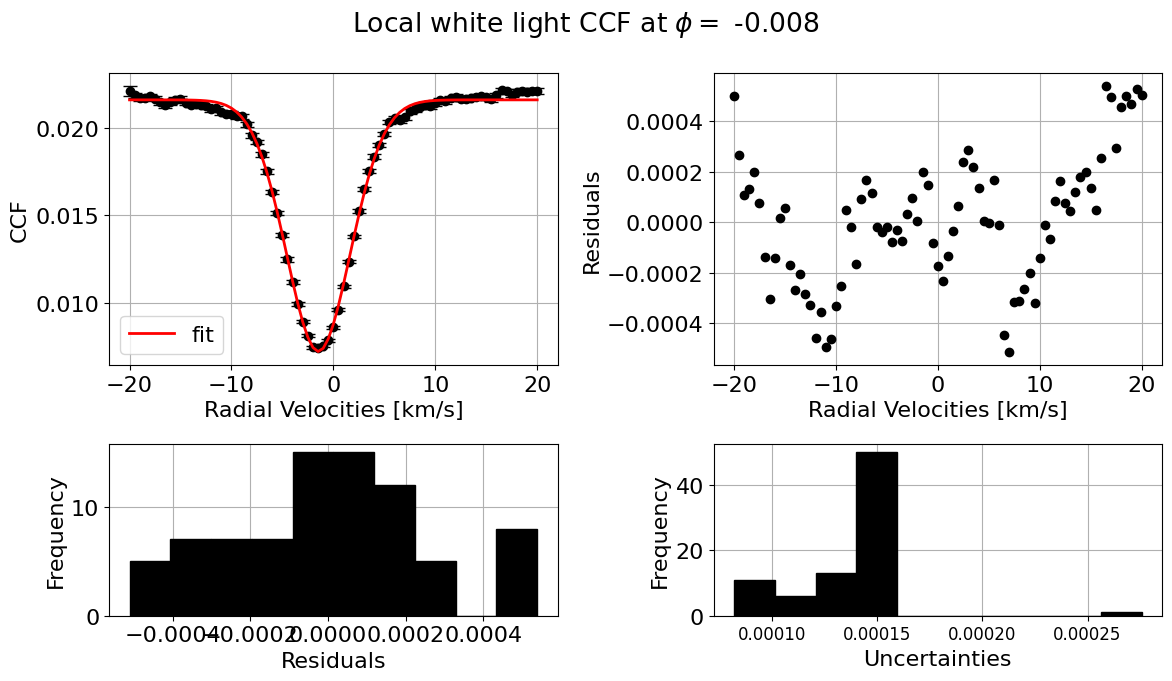

y_0 = 0.0240±1.9696, a = 0.0165±4.6306, x_0 = -1.143±0.0074, sigma = 3.0700±0.0134, c = 1.8892±0.0148


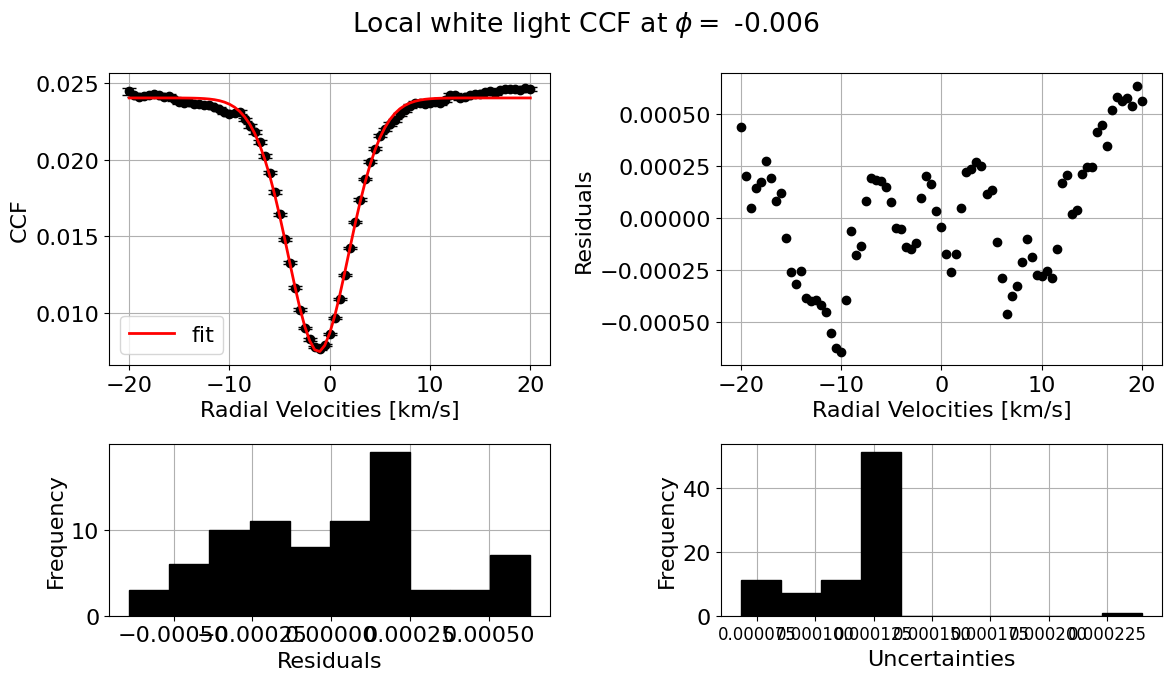

y_0 = 0.0253±1.8832, a = 0.0178±4.3908, x_0 = -0.881±0.0065, sigma = 3.0306±0.0117, c = 1.9063±0.0133


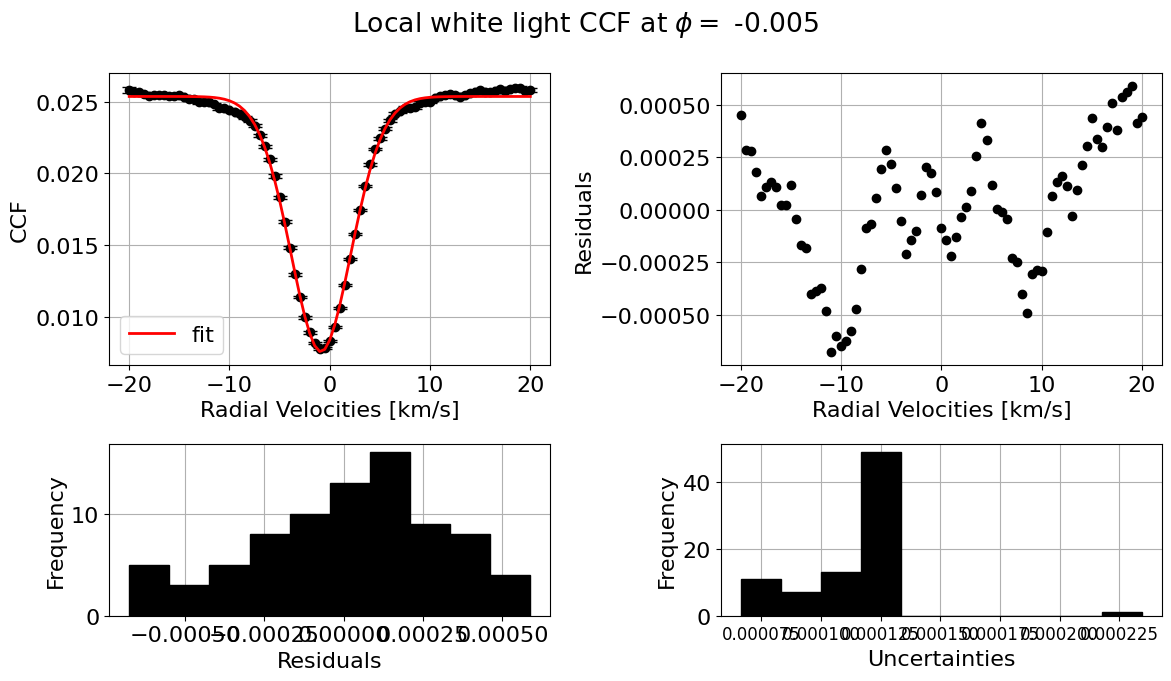

y_0 = 0.0260±1.8222, a = 0.0184±4.2182, x_0 = -0.546±0.0060, sigma = 3.0024±0.0109, c = 1.8773±0.0122


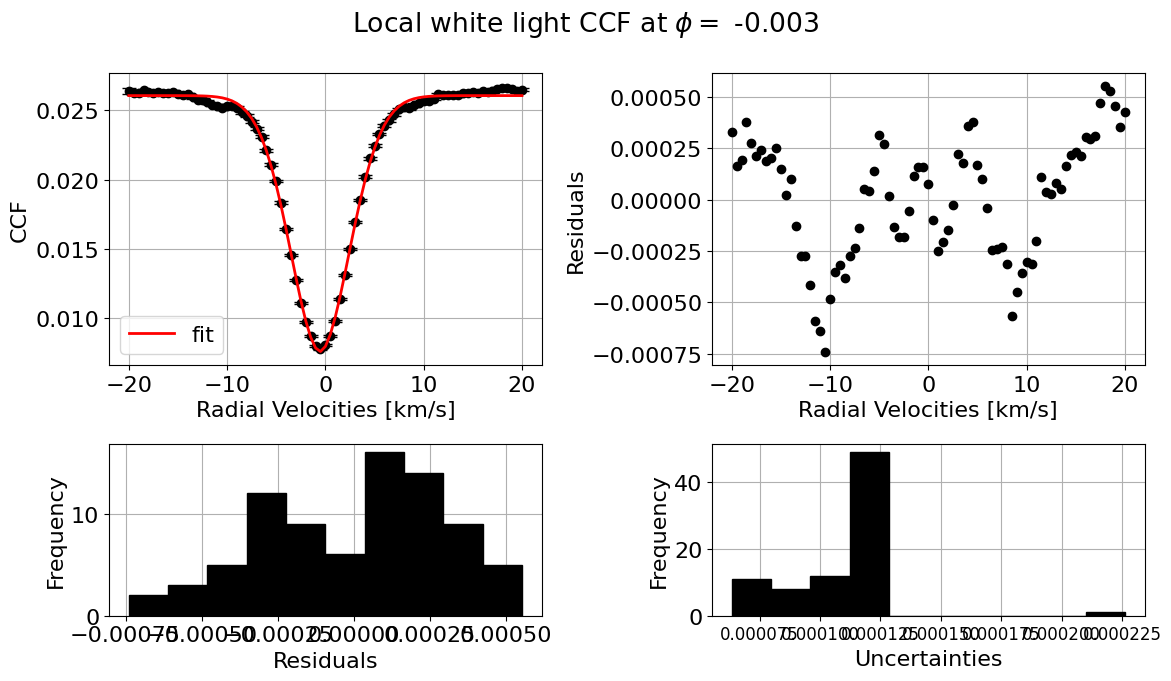

y_0 = 0.0266±1.8091, a = 0.0189±4.1930, x_0 = -0.244±0.0058, sigma = 3.0363±0.0105, c = 1.9293±0.0124


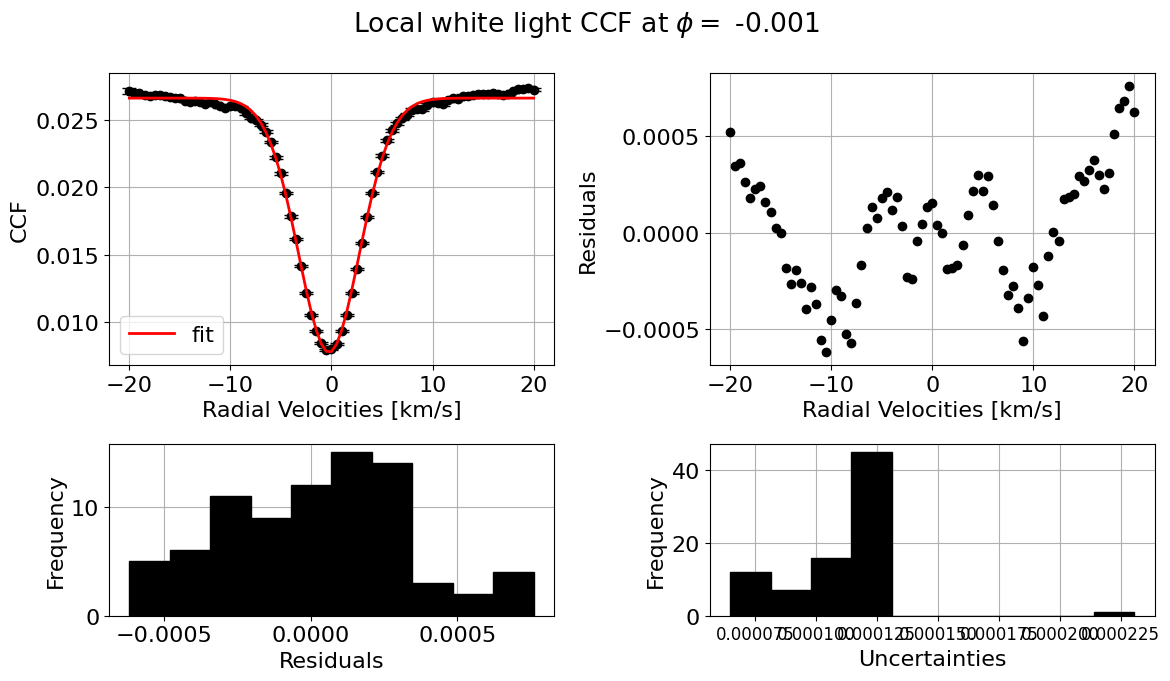

y_0 = 0.0267±1.8918, a = 0.0190±4.3772, x_0 = 0.0597±0.0061, sigma = 3.0193±0.0110, c = 1.8870±0.0124


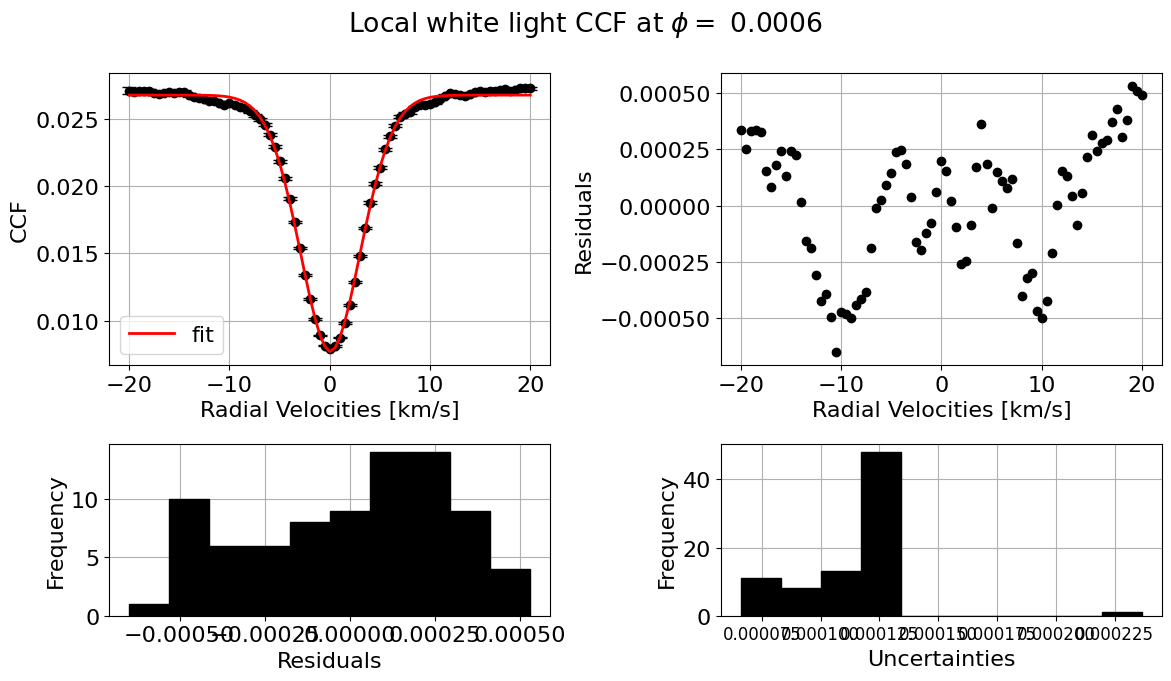

y_0 = 0.0264±1.8586, a = 0.0187±4.2920, x_0 = 0.3760±0.0061, sigma = 3.0376±0.0110, c = 1.9100±0.0126


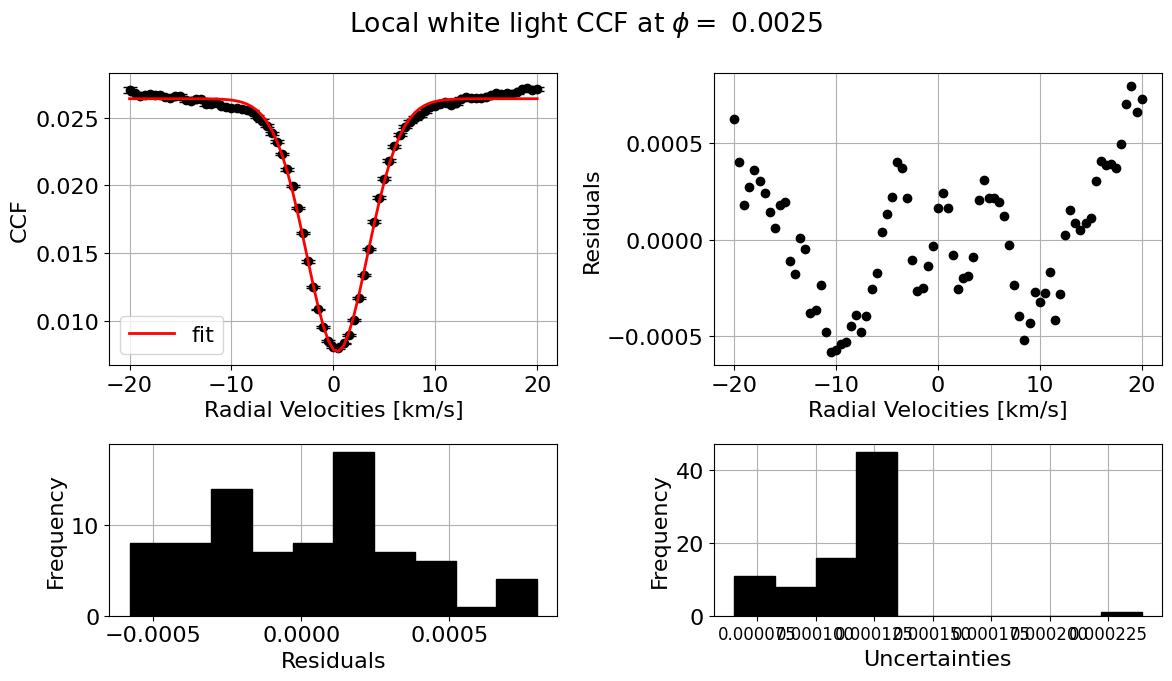

y_0 = 0.0255±1.7860, a = 0.0183±4.2481, x_0 = 0.7330±0.0060, sigma = 2.9844±0.0110, c = 1.8724±0.0122


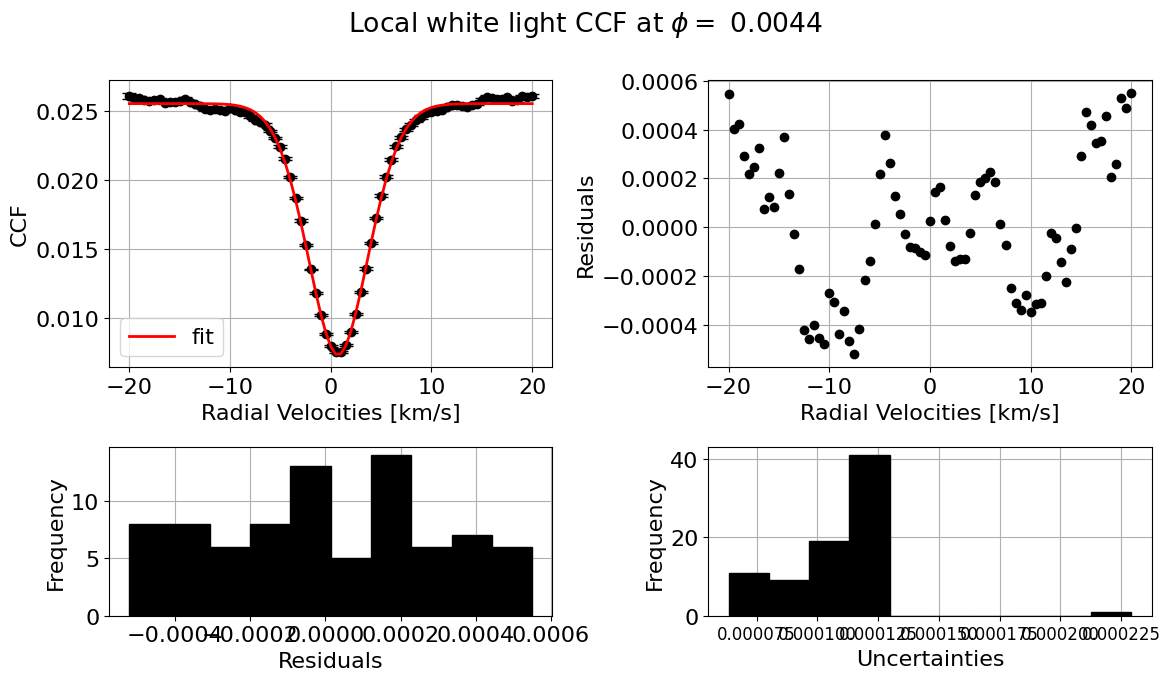

y_0 = 0.0245±1.8385, a = 0.0172±4.3629, x_0 = 1.0342±0.0066, sigma = 3.0186±0.0120, c = 1.8799±0.0133


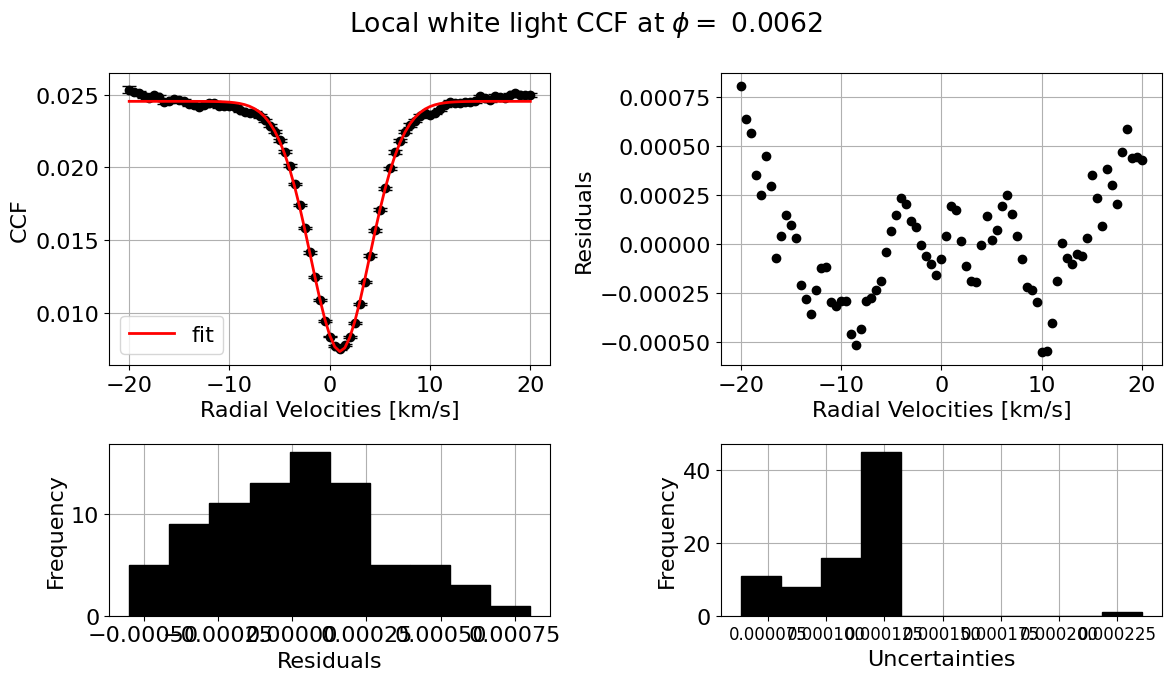

y_0 = 0.0225±1.8533, a = 0.0156±4.4885, x_0 = 1.3410±0.0074, sigma = 3.0271±0.0135, c = 1.8948±0.0150


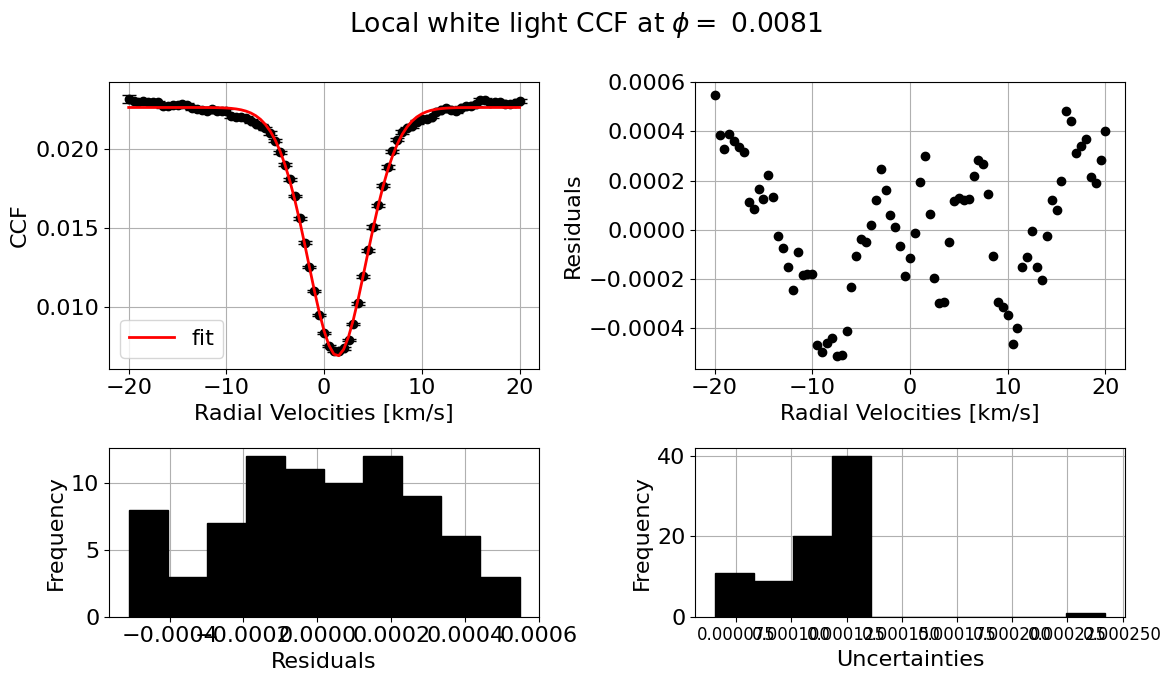

y_0 = 0.0186±1.8226, a = 0.0127±4.4716, x_0 = 1.6459±0.0090, sigma = 3.0403±0.0165, c = 1.8890±0.0181


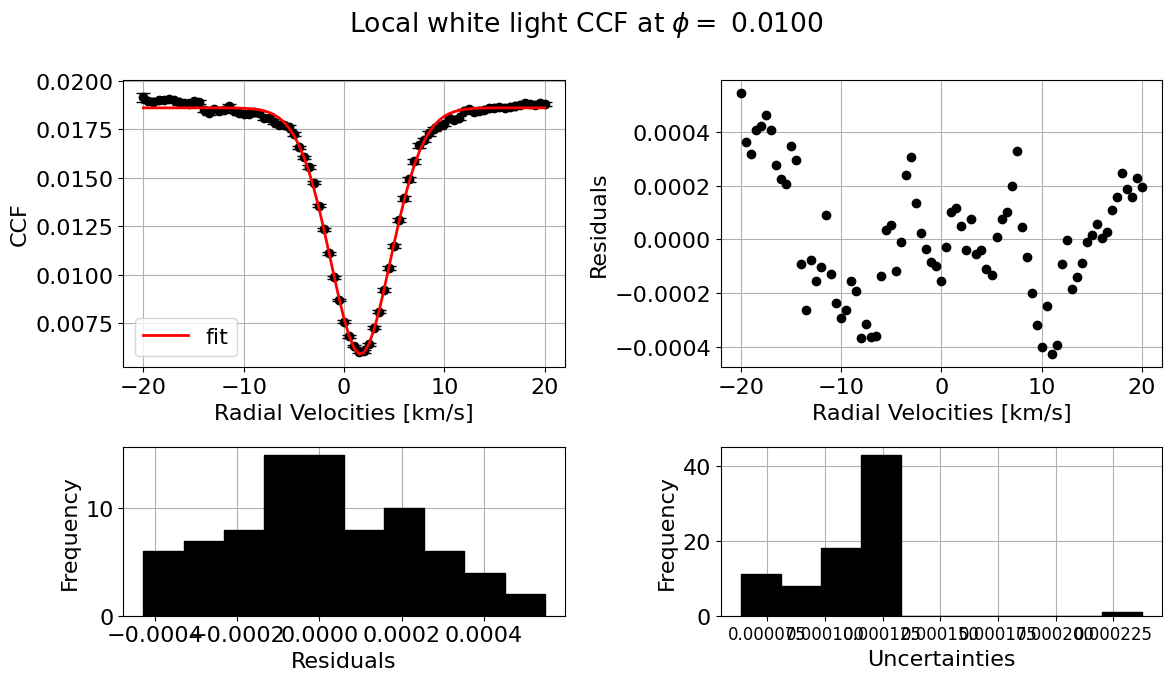

y_0 = 0.0125±1.8167, a = 0.0083±4.4652, x_0 = 1.9100±0.0139, sigma = 3.0999±0.0251, c = 1.9511±0.0287


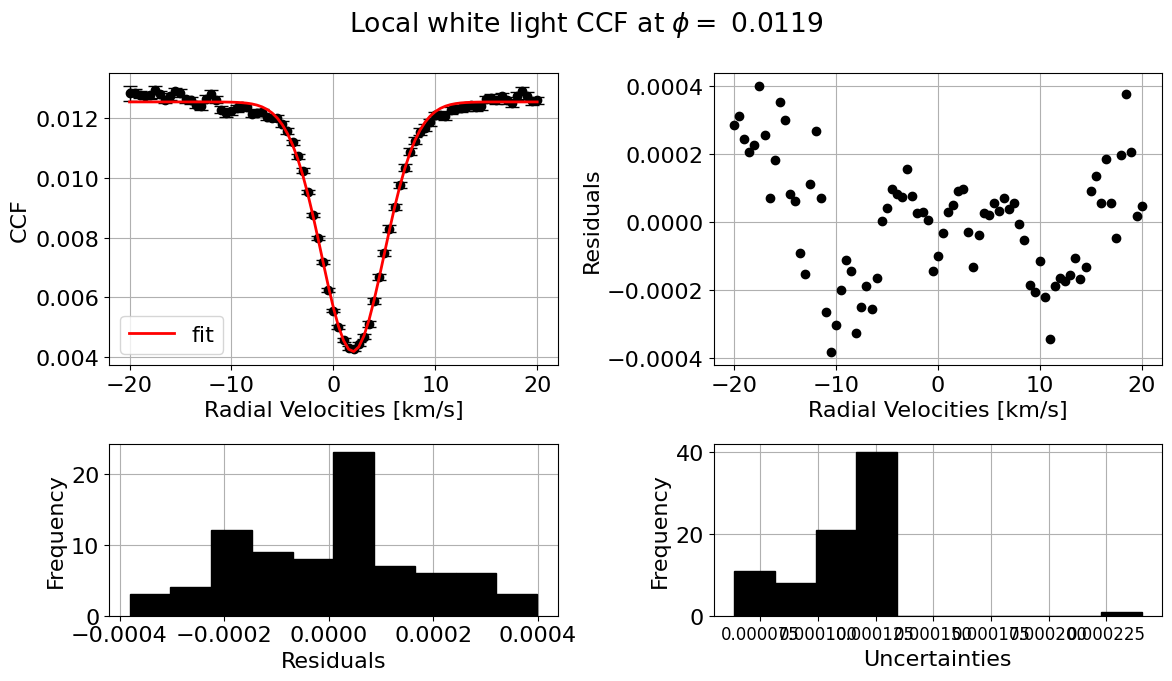

y_0 = 0.0063±1.6958, a = 0.0042±4.1603, x_0 = 2.1002±0.0257, sigma = 3.1244±0.0437, c = 2.2000±0.0633


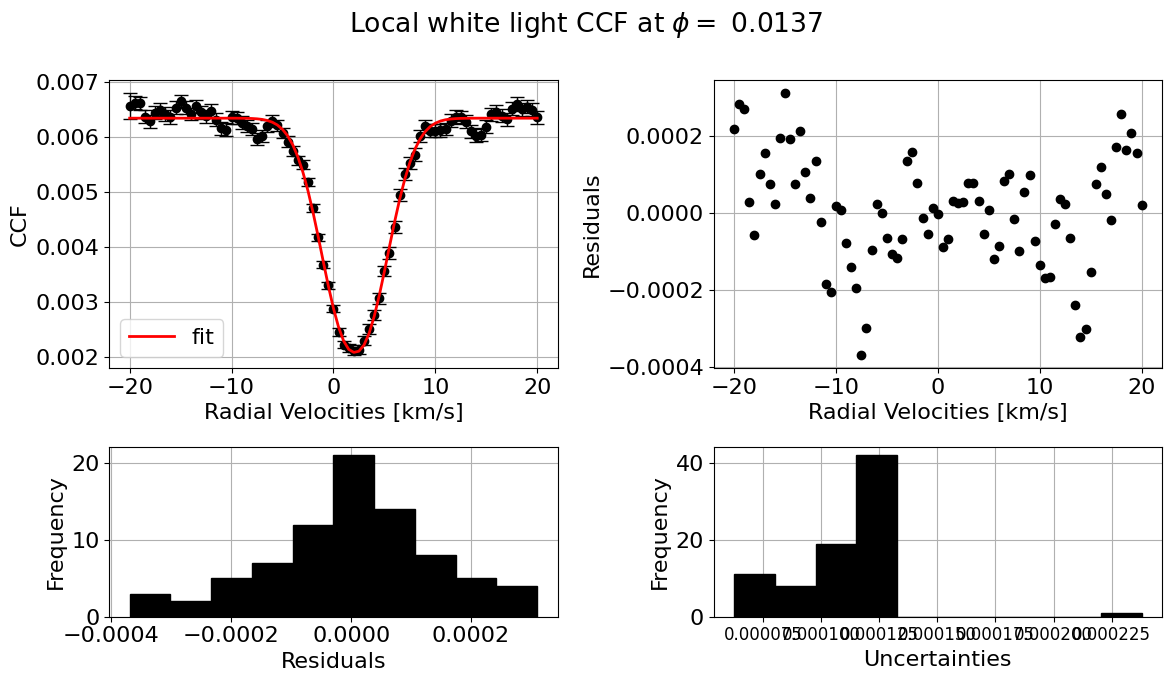

y_0 = 0.0015±1.5594, a = 0.0011±3.8618, x_0 = 1.8989±0.0840, sigma = 2.9330±0.1350, c = 2.5411±0.2799


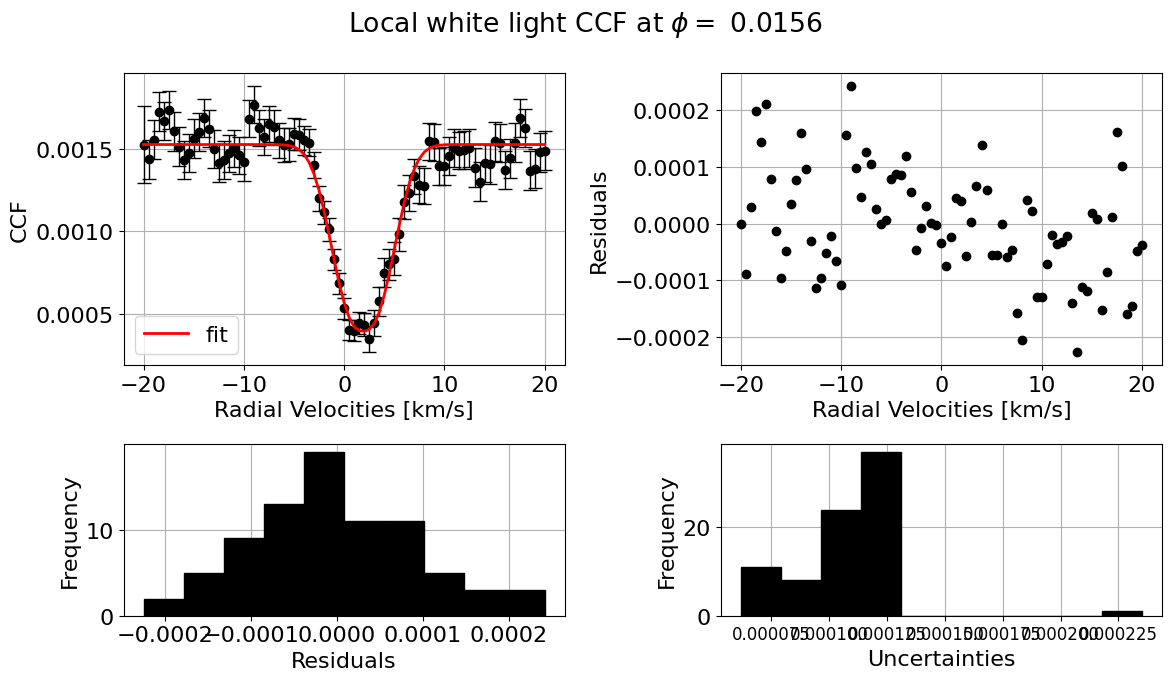

In [ ]:
#in transit local CCFs parameter fitting
in_phases = phases[np.isin(np.arange(len(phases)), in_indices)]
mu_in = mu(in_phases)

y0_local = np.zeros((local_CCFs.shape[0],2))
x0_local = np.zeros((local_CCFs.shape[0],2))
width_local = np.zeros((local_CCFs.shape[0],2))
depth_local = np.zeros((local_CCFs.shape[0],2))

RR2 = []

for i in range(local_CCFs.shape[0]):

    d = local_CCFs[i,0]
    de = local_CCFs[i,1]

    p0 =          [np.max(d), np.max(d)-np.min(d),           0,       1,       1] #y0, a, x0, sigma, c
    upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
    lower_bound = [        0,                   0,  np.min(rv),       0,       0]

    popt, pcov = curve_fit(f=modified_gaussfit, xdata=RV_target, ydata=d, sigma=de, 
                           bounds=(lower_bound,upper_bound), absolute_sigma=True, p0=p0)
    gd = modified_gaussfit(RV_target, popt[0], popt[1], popt[2], popt[3], popt[4])

    print('y_0 = '+str(popt[0])[:6]+'±'+str(np.sqrt(pcov[0,0]))[:6]+', a = '+str(popt[1])[:6]+'±'+str(np.sqrt(pcov[1,1]))[:6]+', x_0 = '+str(popt[2])[:6]+'±'+str(np.sqrt(pcov[2,2]))[:6]+', sigma = '+str(popt[3])[:6]+'±'+str(np.sqrt(pcov[3,3]))[:6]+', c = '+str(popt[4])[:6]+'±'+str(np.sqrt(pcov[4,4]))[:6])

    y0_local[i,0], y0_local[i,1] = popt[0], np.sqrt(pcov[0,0])
    x0_local[i,0], x0_local[i,1] = popt[2], np.sqrt(pcov[2,2])
    width_local[i,0], width_local[i,1] = popt[3], np.sqrt(pcov[3,3])
    depth_local[i,0], depth_local[i,1] = (1-popt[1]/popt[0])*100, ((popt[1]/popt[0])*np.sqrt(np.abs(pcov[1,1])/(popt[1]**2)+np.abs(pcov[0,0])/(popt[0]**2)))*100

    RR2.append(r2(d,gd))

        
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7), gridspec_kw={'height_ratios': [1.7, 1]})
    fig.suptitle(rf'Local white light CCF at $\phi = $ {str(in_phases[i])[:6]}')

    axes[0,0].scatter(RV_target, d, color="k")
    axes[0,0].errorbar(RV_target, d, yerr=de,
                    color='black', capsize=5, linewidth=0, elinewidth=1)
    axes[0,0].plot(RV_target, gd, label='fit', color="r", lw=2)
    axes[0,0].set_xlabel('Radial Velocities [km/s]')
    axes[0,0].set_ylabel('CCF')
    axes[0,0].grid()
    axes[0,0].set_axisbelow(True)
    axes[0,0].legend()

    axes[0,1].scatter(RV_target, d-gd, color="k")
    axes[0,1].set_xlabel('Radial Velocities [km/s]')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].grid()
    axes[0,1].set_axisbelow(True)

    axes[1,0].hist(d-gd, bins=10, edgecolor='k', color="k")
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid()
    axes[1,0].set_axisbelow(True)

    axes[1,1].hist(de, bins=10, edgecolor='k', color="k")
    axes[1,1].set_xlabel('Uncertainties')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid()
    axes[1,1].set_axisbelow(True)
    axes[1,1].tick_params(axis='x', which='major', labelsize=12)

    plt.tight_layout()
    plt.show()

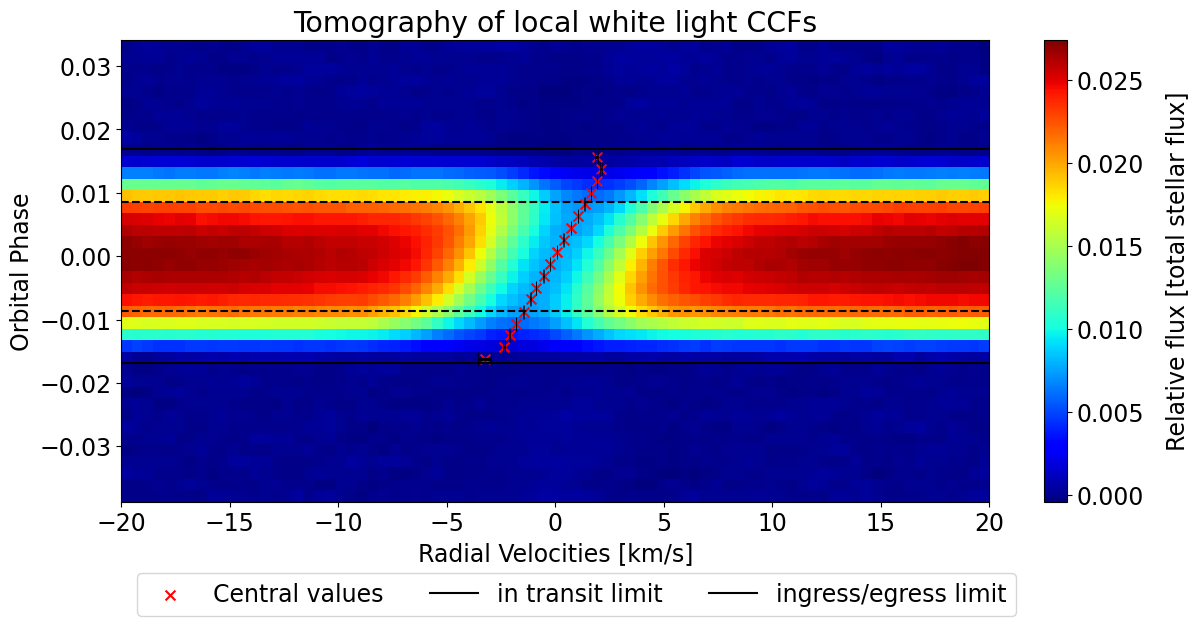

In [ ]:
#tomography
X,Y = np.meshgrid(RV_target, phases)

fig,ax = plt.subplots(figsize=(14,6))

im = ax.imshow(CCFs_sub_all[:,0], cmap='jet', extent=[RV_target.min(), RV_target.max(), phases.min(), phases.max()], 
               aspect='auto', origin='lower')

l1=ax.scatter(x0_local[:,0], in_phases, marker='x', color='red', label='Central RV', s=50)
l2= ax.errorbar(x=x0_local[:,0], y=in_phases, xerr=x0_local[:,1], 
                color='black',capsize=5,capthick=0.5,linewidth=0,elinewidth=2)
l3=ax.axhline(y=-tr_dur/2, color='black')
ax.axhline(y=tr_dur/2, color='black')
l4=ax.axhline(y=-tr_ingress_egress/2, color='black',linestyle='--')
ax.axhline(y=tr_ingress_egress/2, color='black',linestyle='--')

ax.set_xlabel('Radial Velocities [km/s]')
ax.set_ylabel('Orbital Phase')
ax.set_title('Tomography of local white light CCFs')

cbar = plt.colorbar(im)
cbar.set_label('Relative flux [total stellar flux]',labelpad=15)

labels = ['Central values','in transit limit','ingress/egress limit']
fig.legend([l1,l3,l4], labels=labels, loc='lower center',ncol=5, bbox_to_anchor=(0.45, -0.1))
plt.rcParams.update({'font.size': 17})

## Parameters

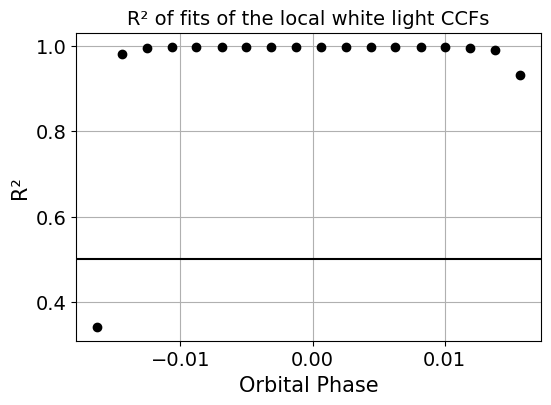

In [89]:
fig, ax = plt.subplots(figsize=(6,4))

l1=ax.scatter(in_phases, RR2, color="k")
ax.axhline(y=0.5,color='black',linestyle='-')

ax.set_title('R² of fits of the local white light CCFs',fontsize=14)
ax.set_xlabel('Orbital Phase',fontsize=15)
ax.set_ylabel('R²',fontsize=15)
ax.grid()
ax.set_axisbelow(True)

plt.show()

In [90]:
#statistical quantities
def chisquare(x,y,m,b,s):
    r = np.sum(((y-(x*m+b))/s)**2)
    rr = np.sum(((y-np.mean(y))/s)**2)
    return [r,rr]

def p_coef(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    a =np.sum((x-xm)*(y-ym))
    aa = np.sum((x-xm)**2)
    aaa = np.sum((y-ym)**2)
    p = a/np.sqrt(aa*aaa)
    return p

def spearman(x,y,y_err):
    n = 10000 
    rho_sim = np.zeros(n)
    p_sim = np.zeros(n) 

    for i in range(n):
        #Generate random weights using mean weights with measurement error
        y_sim = np.random.normal(y,y_err,len(y))
        #Calculate correlation coefficient and p-value
        rho_sim[i],p_sim[i] = spearmanr(x,y_sim)
    return rho_sim,p_sim

In [98]:
#discard points based on R² plot
inner = np.arange(2,len(mu_in)-2)

coefs_poly_rv, cov_poly_rv = np.polyfit(in_phases[inner], x0_local[:,0][inner], w=1/x0_local[:,1][inner], deg=1, cov=True)
chi_x0 = chisquare(in_phases[inner], x0_local[:,0][inner], coefs_poly_rv[0], coefs_poly_rv[1], x0_local[:,0][inner])
pearson_x0 = p_coef(in_phases[inner], x0_local[:,0][inner])
r2_x0 = r2(x0_local[:,0][inner], coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1])
spear_x0, spear_pval_x0 = spearman(in_phases[inner], x0_local[:,0][inner], x0_local[:,1][inner])
spearr_x0, spearr_pval_x0 = spearmanr(in_phases[inner], x0_local[:,0][inner])

print('Central RV in function of orbital phases')
print('\n fit values, m = '+str(coefs_poly_rv[0])[:6]+'±'+str(np.sqrt(cov_poly_rv[0,0]))[:6]+', b = '+str(coefs_poly_rv[1])[:6]+'±'+str(np.sqrt(cov_poly_rv[1,1]))[:6])
print('Χ² = '+str(chi_x0))
print('pearson = '+str(pearson_x0))
print('r² = '+str(r2_x0))
print('spearman = '+str(spearr_x0))
print('p-value = '+str(np.log10(spearr_pval_x0)))
print('\n')

#-------------------

coefs_poly_width, cov_poly_width = np.polyfit(mu_in[inner], width_local[:,0][inner], w=1/width_local[:,1][inner], deg=1, cov=True)
chi_width = chisquare(mu_in[inner], width_local[:,0][inner], coefs_poly_width[0], coefs_poly_width[1], width_local[:,1][inner])
pearson_width = p_coef(mu_in[inner], width_local[:,0][inner])
r2_width = r2(width_local[:,0][inner], coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1])
spear_width, spear_pval_width = spearman(mu_in[inner], width_local[:,0][inner], width_local[:,1][inner])
spearr_width, spearr_pval_width = spearmanr(mu_in[inner], width_local[:,0][inner])

print('Line-width measure in function of mu')
print('\nfit values, m = '+str(coefs_poly_width[0])[:5]+'±'+str(np.sqrt(cov_poly_width[0,0]))[:5]+', b = '+str(coefs_poly_width[1])[:5]+'±'+str(np.sqrt(cov_poly_width[1,1]))[:5])
print('Χ² = '+str(chi_width))
print('pearson = '+str(pearson_width))
print('r² = '+str(r2_width))
print('spearman = '+str(spearr_width))
print('p-value = '+str(np.log10(spearr_pval_width)))
print('\n')

#-------------------

coefs_poly_depth, cov_poly_width = np.polyfit(mu_in[inner], depth_local[:,0][inner], w=1/depth_local[:,1][inner], deg=1, cov=True)
chi_depth = chisquare(mu_in[inner], depth_local[:,0][inner], coefs_poly_depth[0], coefs_poly_depth[1], depth_local[:,1][inner])
pearson_depth = p_coef(mu_in[inner], depth_local[:,0][inner])
r2_depth = r2(depth_local[:,0][inner], coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1])
spear_depth, spear_pval_depth = spearman(mu_in[inner], depth_local[:,0][inner], depth_local[:,1][inner])
spearr_depth, spearr_pval_depth = spearmanr(mu_in[inner], depth_local[:,0][inner])

print('Line-center intensity in function of mu')
print('\n fit values, m = '+str(coefs_poly_depth[0])[:5]+'±'+str(np.sqrt(cov_poly_width[0,0]))[:5]+', b = '+str(coefs_poly_depth[1])[:5]+'±'+str(np.sqrt(cov_poly_width[1,1]))[:5])
print('Χ² = '+str(chi_depth))
print('pearson = '+str(pearson_depth))
print('r² = '+str(r2_depth))
print('spearman = '+str(spearr_depth))
print('p-value = '+str(np.log10(spearr_pval_depth)))

Central RV in function of orbital phases

 fit values, m = 166.71±0.9160, b = -0.028±0.0052
Χ² = [0.08632471891128349, 18.19057210060134]
pearson = 0.9998768076497558
r² = 0.9997333272331969
spearman = 1.0
p-value = -inf


Line-width measure in function of mu

fit values, m = -0.27±0.095, b = 3.211±0.062
Χ² = [85.41741419243026, 193.76307890022775]
pearson = -0.7013530263061573
r² = 0.4852829549182557
spearman = -0.6923076923076923
p-value = -2.2167362797663746


Line-center intensity in function of mu

 fit values, m = -14.0±2.062, b = 38.92±1.330
Χ² = [183.02932103615132, 1220.0469324296841]
pearson = -0.895994385020751
r² = 0.7951989269965862
spearman = -0.9208791208791209
p-value = -5.525558899332922


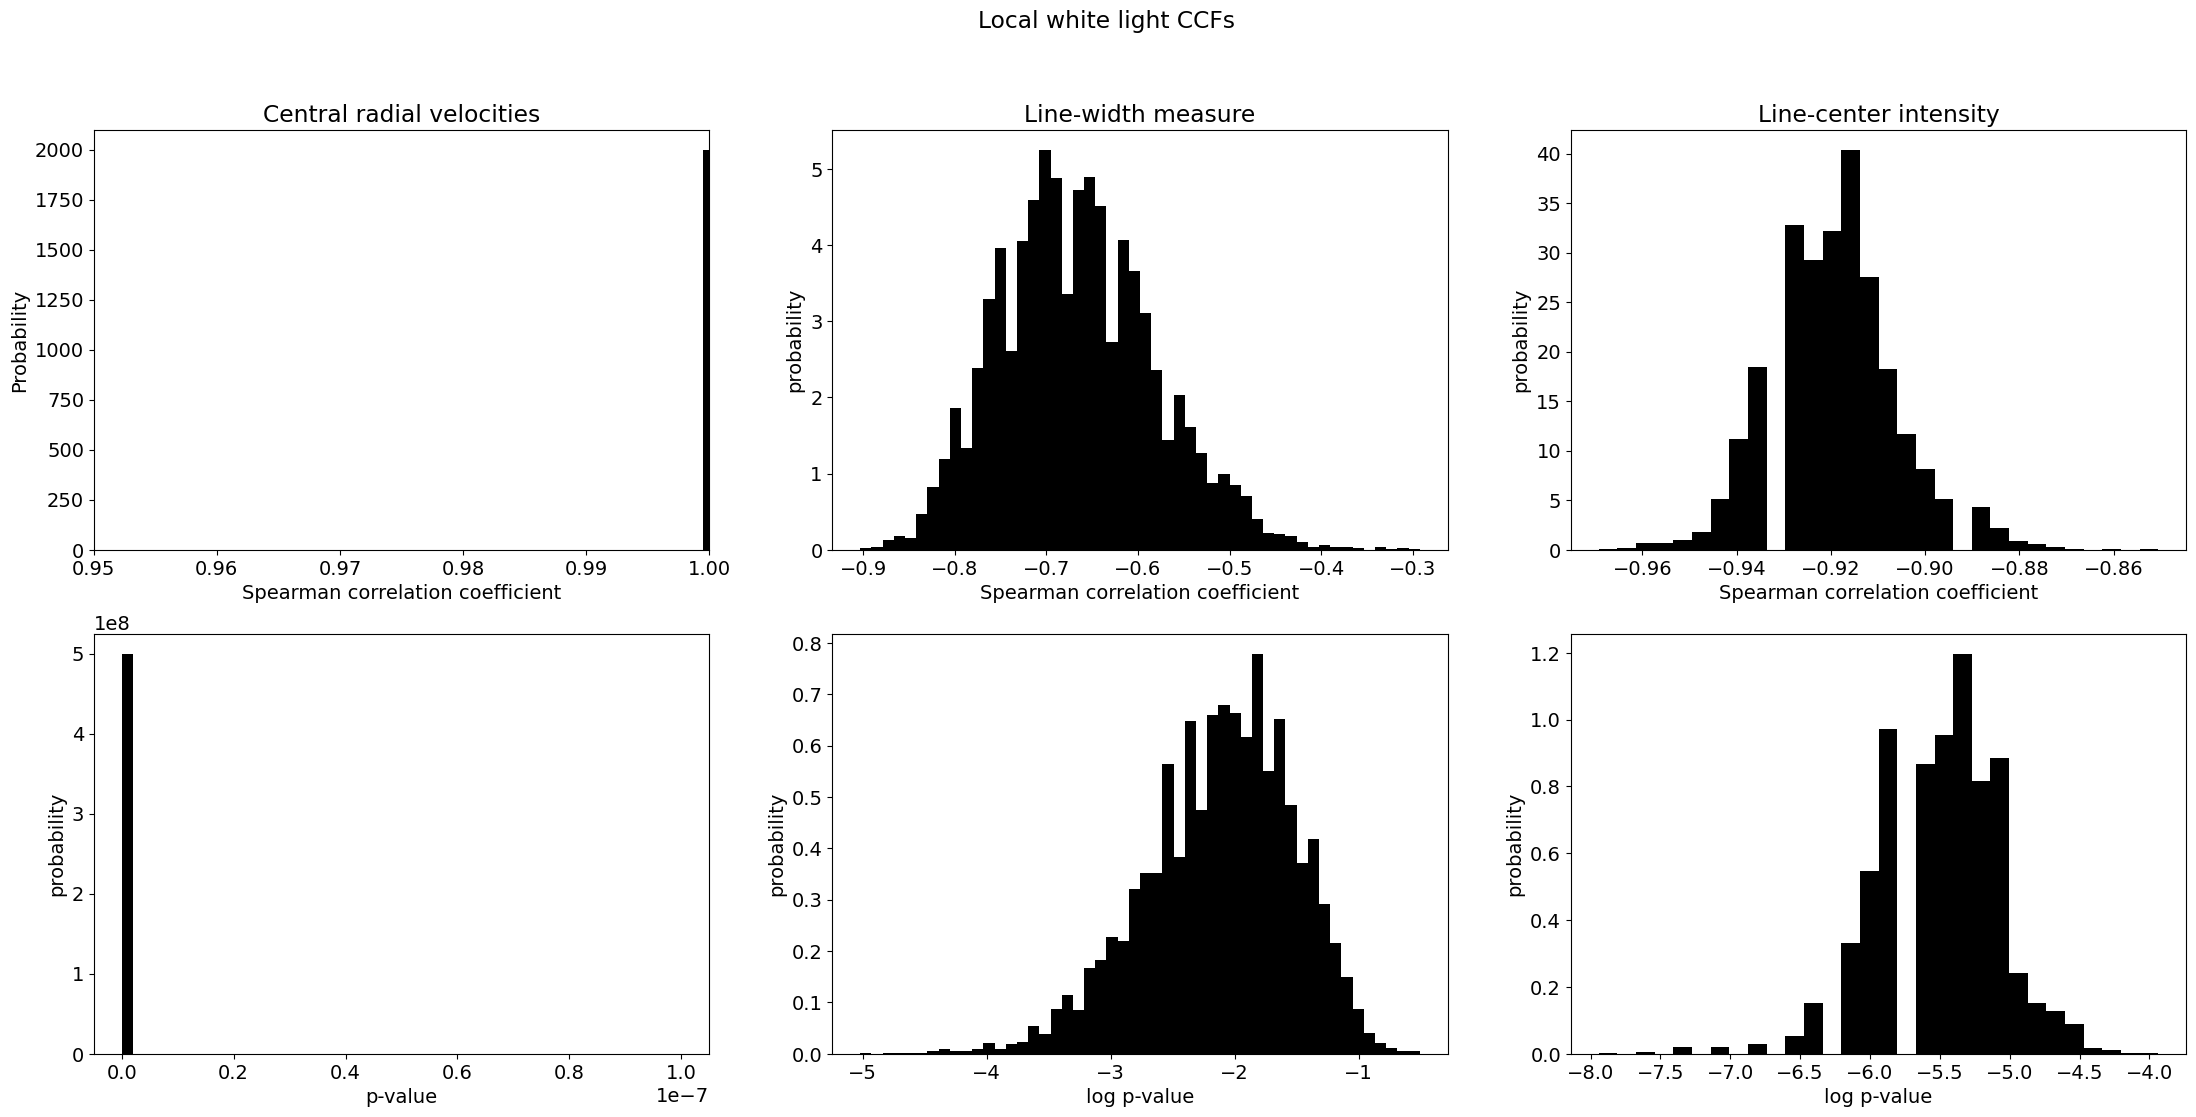

In [102]:
#spearman and p-value distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(27,12))

axes[0,0].hist(np.concatenate((spear_x0[2:], spear_x0[:2]-0.005)), density=True, color='black', bins=10)
axes[0,0].set_title('Central radial velocities')
axes[0,0].set_xlabel('Spearman correlation coefficient')
axes[0,0].set_ylabel('Probability')
axes[0,0].set_xlim((0.95,1))

axes[1,0].hist(np.concatenate((spear_pval_x0[2:], spear_pval_x0[:2]+0.0000001)), density=True, color='black', bins=50)
axes[1,0].set_xlabel('p-value')
axes[1,0].set_ylabel('probability')


axes[0,1].hist(spear_width, density=True, color='black', bins=50)
axes[0,1].set_title('Line-width measure')
axes[0,1].set_xlabel('Spearman correlation coefficient')
axes[0,1].set_ylabel('probability')

axes[1,1].hist(np.log10(spear_pval_width), density=True,color='black',bins=50)
axes[1,1].set_xlabel('log p-value')
axes[1,1].set_ylabel('probability')


axes[0,2].hist(spear_depth,density=True,color='black',bins=30)
axes[0,2].set_title('Line-center intensity')
axes[0,2].set_xlabel('Spearman correlation coefficient')
axes[0,2].set_ylabel('probability')

axes[1,2].hist(np.log10(spear_pval_depth),density=True,color='black',label='day 11 values',bins=30)
axes[1,2].set_xlabel('log p-value')
axes[1,2].set_ylabel('probability')

plt.suptitle('Local white light CCFs')
plt.show()

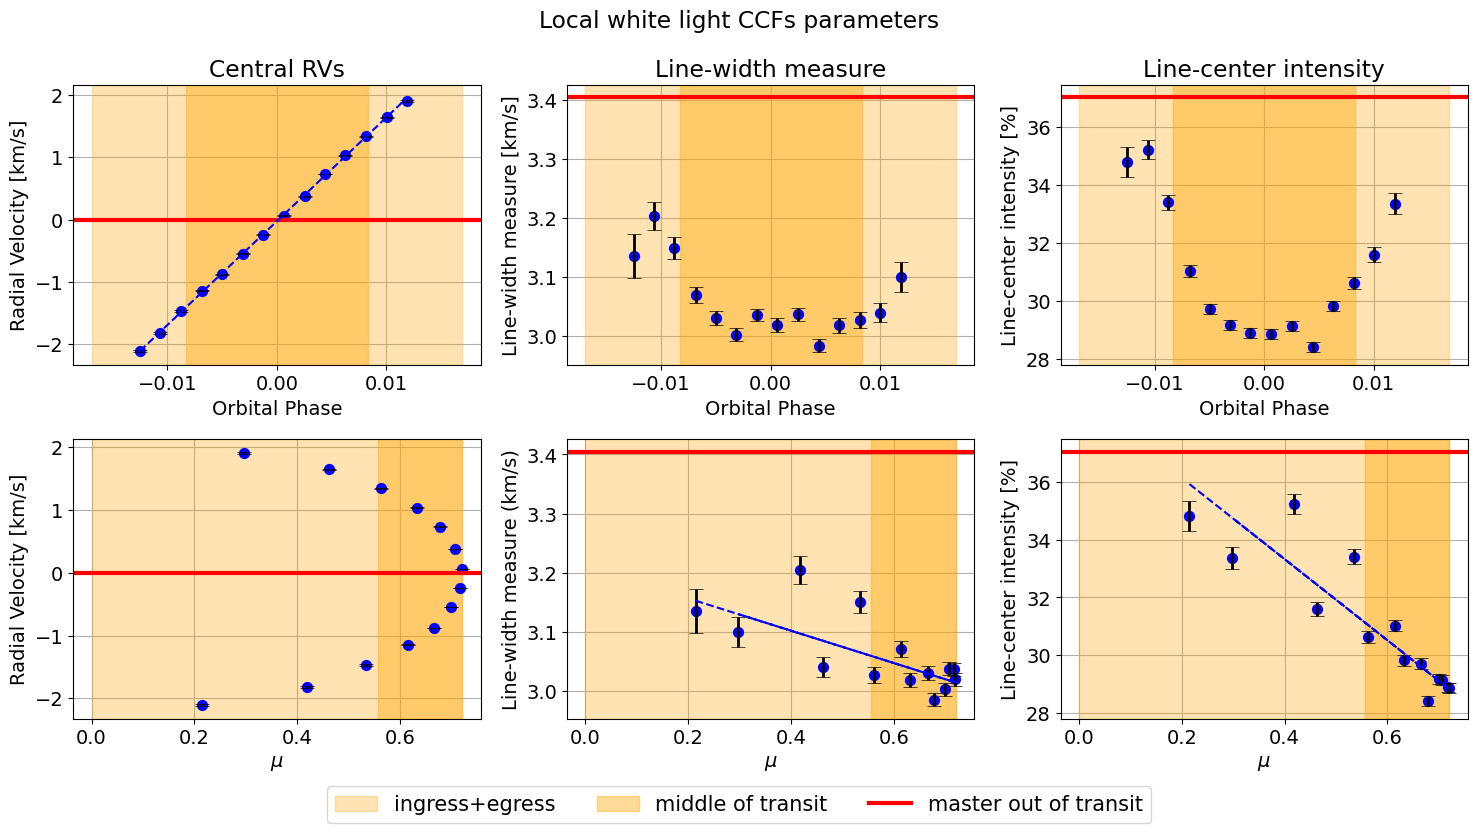

In [123]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

axes[0,0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,0].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,0].axhline(y=master_x0, color='red', linestyle='-', lw=3,)
axes[0,0].scatter(in_phases[inner], x0_local[:,0][inner],color='blue',s=50)
axes[0,0].errorbar(x=in_phases[inner], y=x0_local[:,0][inner], yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[0,0].plot(in_phases[inner], coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1], color='blue', linestyle='--')
axes[0,0].set_title('Central RVs')
axes[0,0].set_xlabel('Orbital Phase')
axes[0,0].set_ylabel('Radial Velocity [km/s]')
axes[0,0].grid()
axes[0,0].set_axisbelow(True)

axes[1,0].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1,0].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1,0].axhline(y=master_x0, color='red', linestyle='-', lw=3)
axes[1,0].scatter(mu_in[inner], x0_local[:,0][inner], color='blue', s=50)
axes[1,0].errorbar(x=mu_in[inner], y=x0_local[:,0][inner], yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[1,0].set_xlabel(r'$\mu$')
axes[1,0].set_ylabel('Radial Velocity [km/s]')
axes[1,0].grid()
axes[1,0].set_axisbelow(True)


axes[0,1].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,1].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,1].axhline(y=master_width, color='red', linestyle='-', lw=3)
axes[0,1].scatter(in_phases[inner], width_local[:,0][inner],color='blue',s=50)
axes[0,1].errorbar(x=in_phases[inner], y=width_local[:,0][inner], yerr=width_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[0,1].set_xlabel('Orbital Phase')
axes[0,1].set_ylabel('Line-width measure [km/s]')
axes[0,1].set_title('Line-width measure')
axes[0,1].grid()
axes[0,1].set_axisbelow(True)

axes[1,1].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1,1].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1,1].axhline(y=master_width, color='red', linestyle='-', lw=3)
axes[1,1].scatter(mu_in[inner], width_local[:,0][inner],color='blue',s=50)
axes[1,1].errorbar(x=mu_in[inner], y=width_local[:,0][inner], yerr=width_local[:,1][inner], capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[1,1].plot(mu_in[inner], coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1], color='blue', linestyle='--')
axes[1,1].set_xlabel(r'$\mu$')
axes[1,1].set_ylabel('Line-width measure (km/s)')
axes[1,1].grid()
axes[1,1].set_axisbelow(True)


axes[0,2].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,2].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,2].axhline(y=master_depth, color='red', linestyle='-', lw=3)
axes[0,2].scatter(in_phases[inner], depth_local[:,0][inner],color='blue',s=50)
axes[0,2].errorbar(x=in_phases[inner], y=depth_local[:,0][inner], yerr=depth_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[0,2].set_xlabel('Orbital Phase')
axes[0,2].set_ylabel('Line-center intensity [%]')
axes[0,2].set_title('Line-center intensity')
axes[0,2].grid()
axes[0,2].set_axisbelow(True)

l0=axes[1,2].axvspan(0, mu_max, alpha=0.3, color='orange')
l1=axes[1,2].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
l2=axes[1,2].axhline(y=master_depth, color='red', linestyle='-', lw=3)
axes[1,2].scatter(mu_in[inner], depth_local[:,0][inner], color='blue', s=50)
axes[1,2].errorbar(x=mu_in[inner],y=depth_local[:,0][inner], yerr=depth_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[1,2].plot(mu_in[inner], coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1], color='blue', linestyle='--')
axes[1,2].set_xlabel(r'$\mu$')
axes[1,2].set_ylabel('Line-center intensity [%]')
axes[1,2].grid()
axes[1,2].set_axisbelow(True)


plt.suptitle('Local white light CCFs parameters')

labels = ['ingress+egress','middle of transit','master out of transit']
fig.legend([l0,l1,l2], labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=15)
plt.tight_layout()
plt.show()

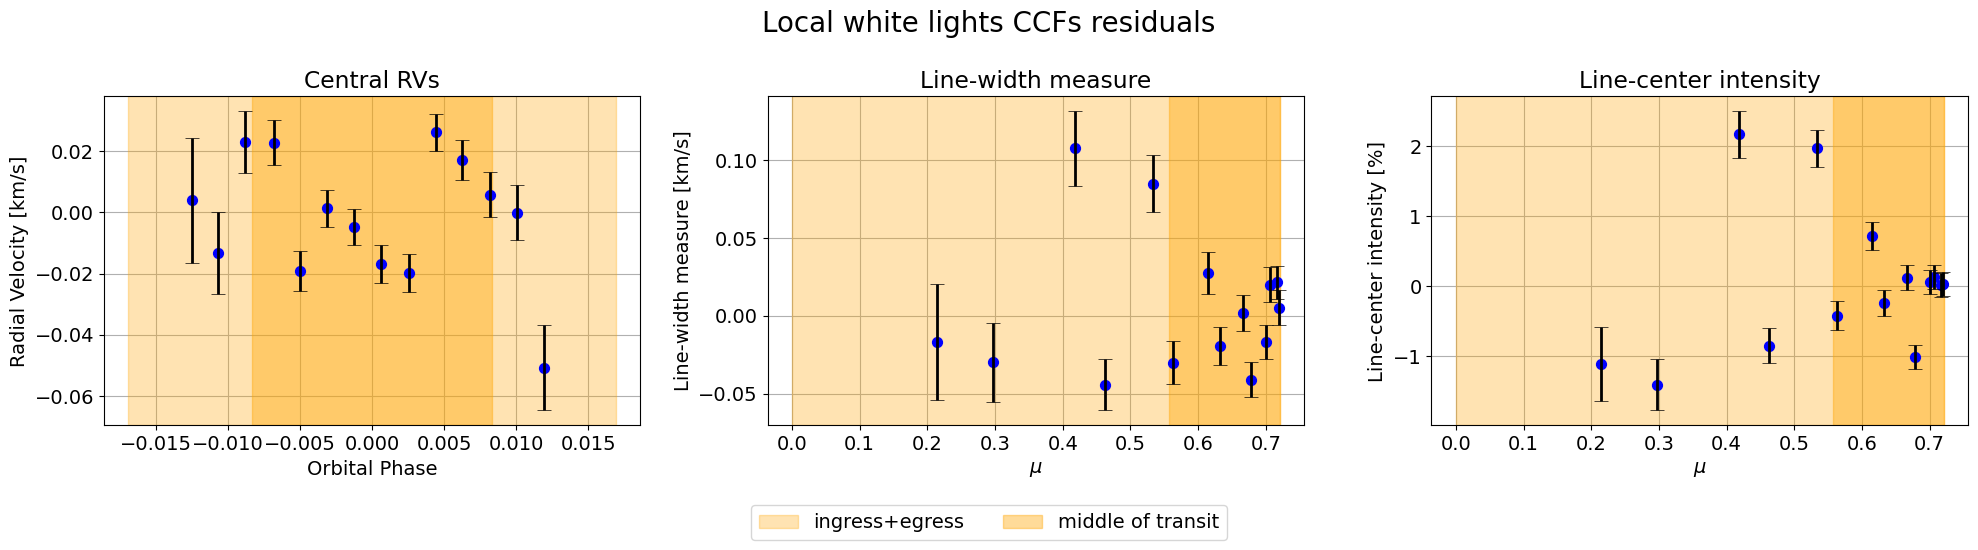

In [137]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

axes[0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0].scatter(in_phases[inner], x0_local[:,0][inner]-(coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1]), color='blue', s=50)
axes[0].errorbar(x=in_phases[inner],y=x0_local[:,0][inner]-(coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1]), yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[0].set_title('Central RVs')
axes[0].set_xlabel('Orbital Phase')
axes[0].set_ylabel('Radial Velocity [km/s]')
axes[0].grid()
axes[0].set_axisbelow(True)

axes[1].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1].scatter(mu_in[inner], width_local[:,0][inner]-(coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1]), color='blue', s=50)
axes[1].errorbar(x=mu_in[inner], y=width_local[:,0][inner]-(coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1]), yerr=width_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[1].set_title('Line-width measure')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_ylabel('Line-width measure [km/s]')
axes[1].grid()
axes[1].set_axisbelow(True)

l0=axes[2].axvspan(0, mu_max, alpha=0.3, color='orange')
l1=axes[2].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[2].scatter(mu_in[inner], depth_local[:,0][inner]-(coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1]), color='blue', s=50)
axes[2].errorbar(x=mu_in[inner], y=depth_local[:,0][inner]-(coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1]), yerr=depth_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[2].set_title('Line-center intensity')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_ylabel('Line-center intensity [%]')
axes[2].grid()
axes[2].set_axisbelow(True)

plt.suptitle('Local white lights CCFs residuals', fontsize=20)

labels = ['ingress+egress','middle of transit']
fig.legend([l0,l1], labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()